In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt

import time
import numpy as np
import pandas as pd
import sqlite3
from matplotlib.transforms import Affine2D

In [3]:
def load_systems_dataframe(ulx_only=False, beamed=False, half_opening_l_45=False):
    systems_df_path = Path('../data/processed/all_systems_df.csv')
    df = pd.read_csv(systems_df_path)
    if ulx_only:
        df = df[df['Lx'] > 1E39]
    if beamed:
        df = df[df['b'] < 1]
    if half_opening_l_45:
        df = df[df['theta_half_deg'] < 45]
        
    df = df.drop(['Unnamed: 0'], axis=1)
    return df

In [4]:
def create_parent_population():    
    systems_df = load_systems_dataframe(True,True,True)
    curve_classifications = pd.read_csv('../data/processed/curve_classifications.csv')

    transient_curves = curve_classifications[curve_classifications['classification'] == 'transient']
    transient_curves['is_bh'] = transient_curves['system_id'].map(systems_df['is_bh'])
    transient_curves['P_wind_days'] = transient_curves['system_id'].map(systems_df['P_wind_days'])
    transient_curves['a*'] = transient_curves['system_id'].map(systems_df['a*'])
    transient_curves['Z'] = transient_curves['system_id'].map(systems_df['Z'])
    transient_curves = transient_curves[transient_curves['P_wind_days'] < 4*365]
    return transient_curves

In [5]:
def col2arr(df, col):
    """Convert an erass column to np [8xN] matrix"""
    return np.array(list(df[col]))

In [42]:
df_ulx = load_systems_dataframe(True,False,False)
systems_df = load_systems_dataframe(True,True,True)
systems_df

iidd    idum       Z  tage     m    mdot  is_bh       mdot_gs  \
3      3805660 -100000  0.0002    10  24.6   36.00      1  2.268994e+21   
27     2171293 -120000  0.0002    10  24.6   11.00      1  6.933037e+20   
28     4750366 -120000  0.0002    10   8.2   26.00      1  1.638718e+21   
37     2415890 -130000  0.0002    10  22.7  430.00      1  2.710187e+22   
40     6407445 -130000  0.0002    10  13.8    9.50      1  5.987623e+20   
...        ...     ...     ...   ...   ...     ...    ...           ...   
2899    213203  -70000  0.0020   100   1.3    1.20      0  7.563313e+19   
2937   3060601  -70000  0.0020   100   1.3    0.72      0  4.537988e+19   
3796   8386096 -140000  0.0002   200   1.3    0.54      0  3.403491e+19   
4073    998543  -10000  0.0002   200   1.3    1.30      0  8.193589e+19   
17261  2943204 -200000  0.0020  1000   1.3    6.10      0  3.844684e+20   

               LEdd      mdot_Edd  ...  r_isco_nospin  r_isco        r_sph  \
3      2.952000e+39  3.936000e+19  ...            6.0    1.25    72.059002   
27     2.952000e+39  3.936000e+19  ...            6.0    1.25    22.018028   
28     9.840000e+38  1.312000e+19  ...            6.0    1.25   156.127837   
37     2.724000e+39  3.632000e+19  ...            6.0    1.25   932.746106   
40     1.656000e+39  2.208000e+19  ...            6.0    1.25    33.897320   
...             ...           ...  ...            ...     ...          ...   
2899   1.560000e+38  2.080000e+18  ...            6.0    6.00   218.172485   
2937   1.560000e+38  2.080000e+18  ...            6.0    6.00   130.903491   
3796   1.560000e+38  2.080000e+18  ...            6.0    6.00    98.177618   
4073   1.560000e+38  2.080000e+18  ...            6.0    6.00   236.353525   
17261  1.560000e+38  2.080000e+18  ...            6.0    6.00  1109.043463   

              r_out  P_inflow_at_rsph    P_envelope        P_wind  \
3      1.367081e+04         11.113106  3.999886e+05  3.485596e+07   
27     9.149313e+02          0.396267  6.842400e+02  1.467619e+04   
28     6.333717e+04         32.554561  5.357578e+06  9.921270e+08   
37     2.252886e+06      14308.533627  8.347314e+10  9.296032e+13   
40     3.219960e+03          0.750650  6.773419e+03  3.022666e+05   
...             ...               ...           ...           ...   
2899   2.679876e+04       1778.998274  2.684140e+07  1.531714e+09   
2937   8.344963e+03        423.079064  1.719364e+06  5.362503e+07   
3796   3.520531e+03        187.551656  2.411639e+05  4.558038e+06   
4073   3.124718e+04       2227.027364  3.892450e+07  2.384751e+09   
17261  6.645419e+05     172099.135653  6.179115e+10  1.691071e+13   

       P_inflow_days  P_envelope_days   P_wind_days  
3           0.000129         4.629498  4.034255e+02  
27          0.000005         0.007919  1.698633e-01  
28          0.000377        62.009001  1.148295e+04  
37          0.165608    966124.248722  1.075930e+09  
40          0.000009         0.078396  3.498455e+00  
...              ...              ...           ...  
2899        0.020590       310.664320  1.772817e+04  
2937        0.004897        19.900050  6.206600e+02  
3796        0.002171         2.791249  5.275507e+01  
4073        0.025776       450.515083  2.760129e+04  
17261       1.991888    715175.325968  1.957258e+08  

[123 rows x 35 columns]

In [43]:
parent_population = create_parent_population()
parent_population

/home/x1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/x1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/x1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

system_id  theta  dincl  inclination        lc_min    lc_max  \
157             3  12.03      1           66  3.137991e-02  0.040252   
158             3  12.03      1           67  2.704656e-02  0.035182   
247             3  12.03      2           65  3.137991e-02  0.050043   
248             3  12.03      2           66  2.704656e-02  0.044988   
249             3  12.03      2           67  2.414519e-02  0.040252   
...           ...    ...    ...          ...           ...       ...   
506499       3796  43.34     45           84  9.300072e-07  2.624724   
506500       3796  43.34     45           85  9.300072e-07  2.600890   
506501       3796  43.34     45           86  9.300072e-07  2.551391   
506502       3796  43.34     45           87  9.300072e-07  2.532188   
506503       3796  43.34     45           88  9.300072e-07  1.409552   

           N_lim classification  is_bh  P_wind_days     a*       Z  
157     0.033004      transient      1   403.425519  0.998  0.0002  
158     0.033004      transient      1   403.425519  0.998  0.0002  
247     0.033317      transient      1   403.425519  0.998  0.0002  
248     0.033317      transient      1   403.425519  0.998  0.0002  
249     0.033317      transient      1   403.425519  0.998  0.0002  
...          ...            ...    ...          ...    ...     ...  
506499  1.254905      transient      0    52.755073  0.010  0.0002  
506500  1.254905      transient      0    52.755073  0.010  0.0002  
506501  1.254905      transient      0    52.755073  0.010  0.0002  
506502  1.254905      transient      0    52.755073  0.010  0.0002  
506503  1.254905      transient      0    52.755073  0.010  0.0002  

[137730 rows x 12 columns]

In [44]:
np.sort(parent_population['system_id'].unique())

array([   3,   27,   40,   53,   56,   74,   82,  109,  114,  133,  148,
        178,  199,  204,  206,  207,  211,  239,  250,  269,  279,  283,
        310,  315,  353,  437,  459,  503,  532,  546,  547,  559,  560,
        593,  615,  621,  623,  706,  764,  791,  804,  894,  907,  917,
        944,  952, 1032, 1071, 1086, 1102, 1135, 1137, 1178, 1226, 1255,
       1343, 1447, 1477, 1485, 1499, 1537, 1600, 1607, 1641, 1662, 1717,
       2937, 3796])

In [45]:
np.sort(parent_population['P_wind_days'].unique())

array([3.58900552e-02, 3.69803133e-02, 4.06906640e-02, 4.26917241e-02,
       5.16903615e-02, 5.58248728e-02, 5.85021782e-02, 6.41930601e-02,
       9.75872178e-02, 1.02842767e-01, 1.45234564e-01, 1.52490195e-01,
       1.54369684e-01, 1.61809156e-01, 1.69863323e-01, 1.82061099e-01,
       1.92805025e-01, 2.62290167e-01, 2.66432803e-01, 2.94335706e-01,
       3.36608202e-01, 3.48685982e-01, 4.45358987e-01, 6.34708045e-01,
       8.82598734e-01, 9.09152689e-01, 9.87806879e-01, 1.05953831e+00,
       1.20522543e+00, 1.25874094e+00, 1.26393107e+00, 2.19899189e+00,
       2.47800246e+00, 3.11309867e+00, 3.49845548e+00, 3.84814647e+00,
       4.58721537e+00, 4.77808049e+00, 5.47224522e+00, 6.10111515e+00,
       7.65272833e+00, 8.98188123e+00, 1.05266655e+01, 1.23135956e+01,
       1.39224888e+01, 1.48265267e+01, 2.89892786e+01, 3.32564979e+01,
       3.36797655e+01, 4.83016593e+01, 5.27550732e+01, 6.11878923e+01,
       8.37557699e+01, 8.59266695e+01, 9.24126018e+01, 1.12505869e+02,
      

In [46]:
parent_population

system_id  theta  dincl  inclination        lc_min    lc_max  \
157             3  12.03      1           66  3.137991e-02  0.040252   
158             3  12.03      1           67  2.704656e-02  0.035182   
247             3  12.03      2           65  3.137991e-02  0.050043   
248             3  12.03      2           66  2.704656e-02  0.044988   
249             3  12.03      2           67  2.414519e-02  0.040252   
...           ...    ...    ...          ...           ...       ...   
506499       3796  43.34     45           84  9.300072e-07  2.624724   
506500       3796  43.34     45           85  9.300072e-07  2.600890   
506501       3796  43.34     45           86  9.300072e-07  2.551391   
506502       3796  43.34     45           87  9.300072e-07  2.532188   
506503       3796  43.34     45           88  9.300072e-07  1.409552   

           N_lim classification  is_bh  P_wind_days     a*       Z  
157     0.033004      transient      1   403.425519  0.998  0.0002  
158     0.033004      transient      1   403.425519  0.998  0.0002  
247     0.033317      transient      1   403.425519  0.998  0.0002  
248     0.033317      transient      1   403.425519  0.998  0.0002  
249     0.033317      transient      1   403.425519  0.998  0.0002  
...          ...            ...    ...          ...    ...     ...  
506499  1.254905      transient      0    52.755073  0.010  0.0002  
506500  1.254905      transient      0    52.755073  0.010  0.0002  
506501  1.254905      transient      0    52.755073  0.010  0.0002  
506502  1.254905      transient      0    52.755073  0.010  0.0002  
506503  1.254905      transient      0    52.755073  0.010  0.0002  

[137730 rows x 12 columns]

In [47]:
curve_classifications = pd.read_csv('../data/processed/curve_classifications.csv')

curve_classifications['is_bh'] = curve_classifications['system_id'].map(systems_df['is_bh'])

alive = curve_classifications[curve_classifications['classification'] == 'alive']
transient = curve_classifications[curve_classifications['classification'] == 'transient']
dead = curve_classifications[curve_classifications['classification'] == 'dead']

N_alive = len(alive)
N_transient = len(transient)
N_dead = len(dead)


In [48]:
transient

system_id  theta  dincl  inclination    lc_min    lc_max     N_lim  \
157             3  12.03      1           66  0.031380  0.040252  0.033004   
158             3  12.03      1           67  0.027047  0.035182  0.033004   
247             3  12.03      2           65  0.031380  0.050043  0.033317   
248             3  12.03      2           66  0.027047  0.044988  0.033317   
249             3  12.03      2           67  0.024145  0.040252  0.033317   
...           ...    ...    ...          ...       ...       ...       ...   
514873      17261   4.58     45           86  0.000004  0.474002  0.320879   
514874      17261   4.58     45           87  0.000004  0.447798  0.320879   
514875      17261   4.58     45           88  0.000004  0.410134  0.320879   
514876      17261   4.58     45           89  0.000004  0.387256  0.320879   
514877      17261   4.58     45           90  0.000004  0.355711  0.320879   

       classification  is_bh  
157         transient      1  
158         transient      1  
247         transient      1  
248         transient      1  
249         transient      1  
...               ...    ...  
514873      transient      0  
514874      transient      0  
514875      transient      0  
514876      transient      0  
514877      transient      0  

[238956 rows x 9 columns]

In [49]:
erass_cols = ['eRASS1', 'eRASS2', 'eRASS3', 'eRASS4', 'eRASS5', 'eRASS6', 'eRASS7', 'eRASS8']

conn = sqlite3.connect('../src/erass.db')
erass_sample = pd.read_sql_query("SELECT * from sampResults", conn)
conn.close()

erass_sample['dincl'] = erass_sample['curve_id'].map(parent_population['dincl'])
erass_sample['inclination'] = erass_sample['curve_id'].map(parent_population['inclination'])
erass_sample['system_id'] = erass_sample['curve_id'].map(parent_population['system_id'])
erass_sample['is_bh'] = erass_sample['curve_id'].map(parent_population['is_bh'])

erass_sample

curve_id  eRASS1  eRASS2  eRASS3  eRASS4  eRASS5  eRASS6  eRASS7  \
0           4333     0.0  0.7977  1.0000  1.0000  1.0000  1.0000  1.0000   
1           4334     0.0  0.4984  0.6977  0.8489  1.0000  1.0000  1.0000   
2           4423     0.0  0.5610  0.7573  0.8767  1.0000  1.0000  1.0000   
3           4424     0.0  0.8002  1.0000  1.0000  1.0000  1.0000  1.0000   
4           4425     0.0  0.7668  0.9716  0.9872  1.0000  1.0000  1.0000   
...          ...     ...     ...     ...     ...     ...     ...     ...   
110452    506499     0.0  0.2759  0.4149  0.5583  0.6964  0.6964  0.6964   
110453    506500     0.0  0.2472  0.3718  0.4973  0.6238  0.6238  0.6238   
110454    506501     0.0  0.2021  0.3045  0.4086  0.5049  0.5049  0.5049   
110455    506502     0.0  0.1498  0.2261  0.3021  0.3811  0.3811  0.3811   
110456    506503     0.0  0.0729  0.1092  0.1463  0.1818  0.1818  0.1818   

        eRASS8  dincl  inclination  system_id  is_bh  
0       1.0000      1           56         27      1  
1       1.0000      1           57         27      1  
2       1.0000      2           55         27      1  
3       1.0000      2           56         27      1  
4       1.0000      2           57         27      1  
...        ...    ...          ...        ...    ...  
110452  0.6964     45           84       3796      0  
110453  0.6238     45           85       3796      0  
110454  0.5049     45           86       3796      0  
110455  0.3811     45           87       3796      0  
110456  0.1818     45           88       3796      0  

[110457 rows x 13 columns]

i < 0 | N_transient = 0
i < 10 | N_transient = 1928
i < 20 | N_transient = 8276
i < 30 | N_transient = 20009
i < 40 | N_transient = 36913
i < 50 | N_transient = 57744
i < 60 | N_transient = 78532
i < 70 | N_transient = 94477
i < 80 | N_transient = 104918


Text(0.5, 1.0, 'chaning inclination')

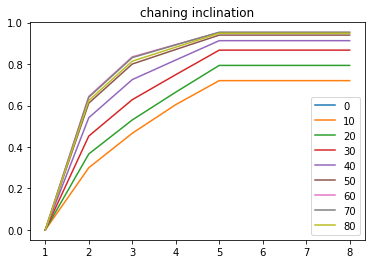

In [50]:
import matplotlib.pyplot as plt
for i in [0,10,20,30,40,50,60,70,80]:
    subset = erass_sample[erass_sample['inclination'] < i]
    erass_columns = subset[['eRASS1', 'eRASS2', 'eRASS3', 'eRASS4', 'eRASS5', 'eRASS6', 'eRASS7','eRASS8']]
    N_transient = len(erass_columns)
    plt.plot([1,2,3,4,5,6,7,8], erass_columns.sum()/N_transient, label=i)
    print(f'i < {i} | N_transient = {N_transient}')
plt.legend()
plt.title('chaning inclination')

dincl<10, N_transient=4860
dincl<20, N_transient=20520
dincl<30, N_transient=46980
dincl<40, N_transient=84053
dincl<45, N_transient=105892


Text(0.5, 1.0, 'chaning dincl')

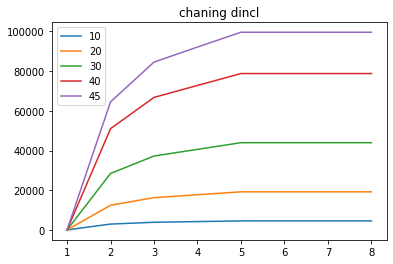

In [51]:
import matplotlib.pyplot as plt

for i in [10,20,30,40,45]:
    subset = erass_sample[erass_sample['dincl'] < i]
    erass_columns = subset[['eRASS1', 'eRASS2', 'eRASS3', 'eRASS4', 'eRASS5', 'eRASS6', 'eRASS7', 'eRASS8']]
    N_transient = len(erass_columns)
    plt.plot([1,2,3,4,5,6,7,8], erass_columns.sum(), label=i)
    print(f'dincl<{i}, N_transient={N_transient}')
plt.legend()
plt.title('chaning dincl')

dincl < 10 N_alive: 59470 N_transient: 4860
dincl < 20 N_alive: 106156 N_transient: 20520
dincl < 30 N_alive: 140380 N_transient: 46980
dincl < 40 N_alive: 163260 N_transient: 84053
dincl < 45 N_alive: 171072 N_transient: 105892


Text(0.5, 1.0, 'chaning dincl')

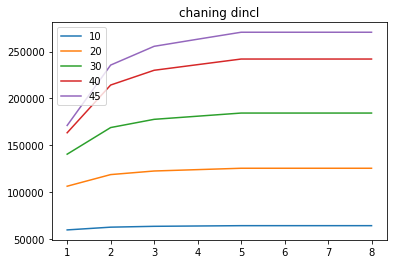

In [52]:
for i in [10,20,30,40,45]:
    subset = erass_sample[erass_sample['dincl'] < i]
    alive_sub = alive[alive['dincl'] < i]
    N_alive = len(alive_sub)
    erass_columns = subset[['eRASS1', 'eRASS2', 'eRASS3', 'eRASS4', 'eRASS5', 'eRASS6', 'eRASS7', 'eRASS8']]
    N_transient = len(erass_columns)
    plt.plot([1,2,3,4,5,6,7,8], erass_columns.sum()+N_alive, label=i)
    print(f'dincl < {i} N_alive: {N_alive} N_transient: {N_transient}')
plt.legend()
plt.title('chaning dincl')

<Figure size 576x576 with 0 Axes>

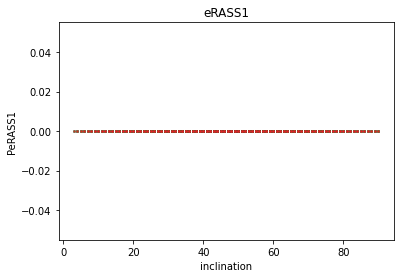

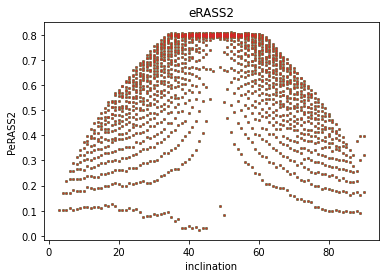

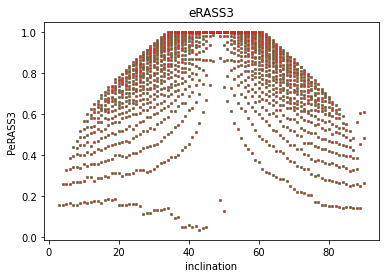

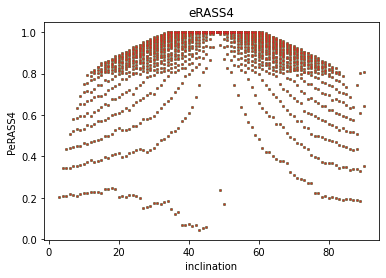

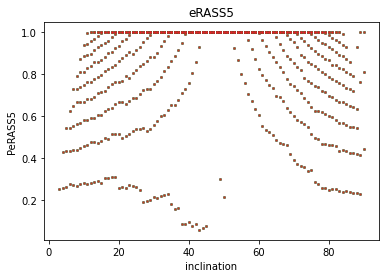

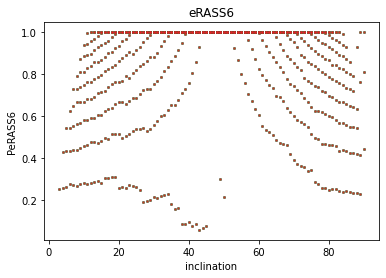

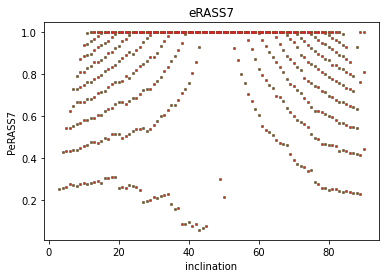

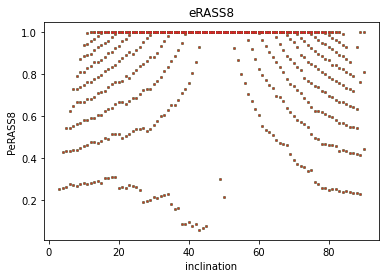

In [53]:
plt.figure(figsize=(8,8))

for col in erass_cols:
    plt.figure()
    plt.title(col)
    for id in erass_sample['system_id'].unique():
        sub = erass_sample[erass_sample['system_id']==74]
        plt.scatter(sub['inclination'], sub[col], s=0.5)
    plt.xlabel('inclination')
    plt.ylabel('P'+col)

In [54]:
erass_sample['system_id'].unique()

array([  27,   40,   53,   56,   74,   82,  133,  148,  178,  199,  206,
        207,  239,  250,  269,  279,  283,  310,  315,  437,  503,  546,
        547,  559,  560,  615,  621,  764,  804,  894,  907,  917,  944,
        952, 1032, 1071, 1086, 1102, 1135, 1137, 1178, 1226, 1255, 1343,
       1477, 1485, 1499, 1537, 1607, 1641, 1662, 1717, 2937, 3796])

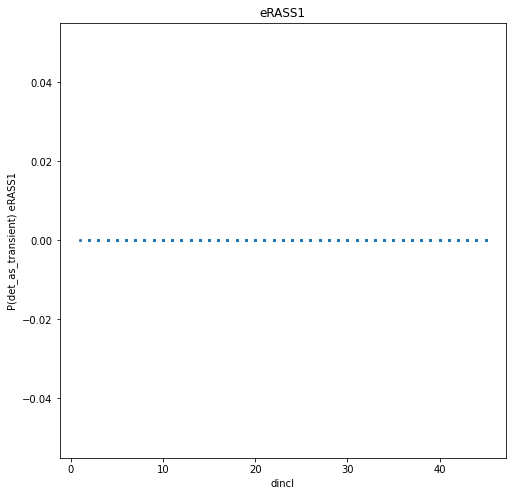

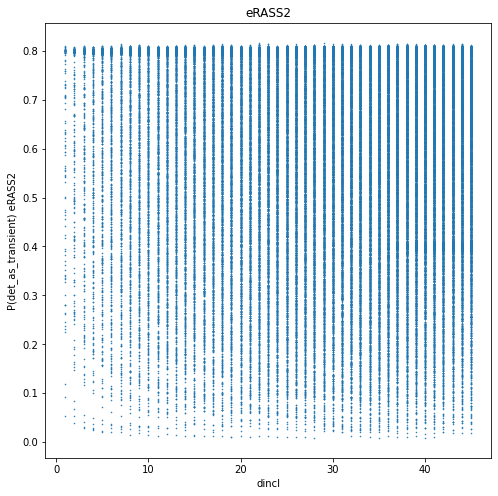

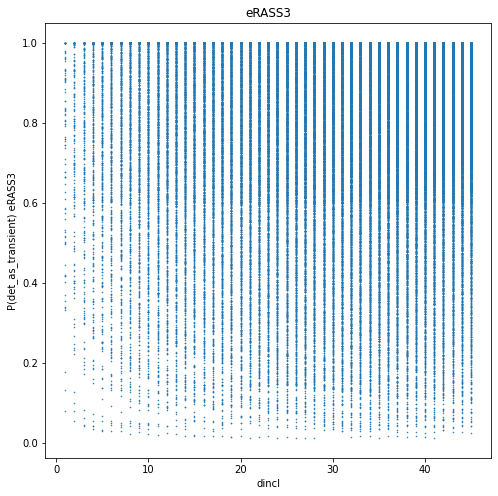

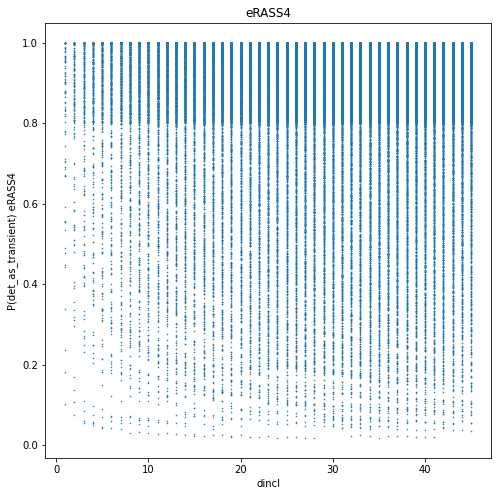

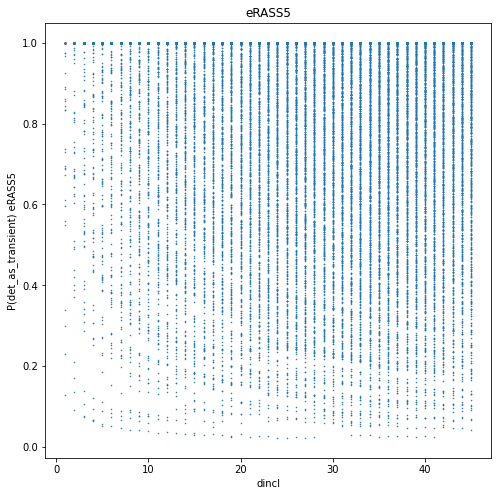

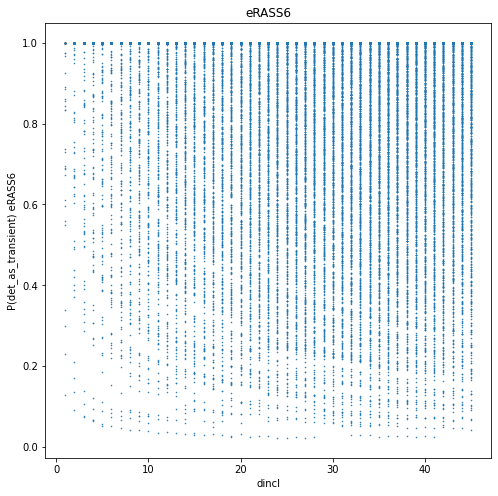

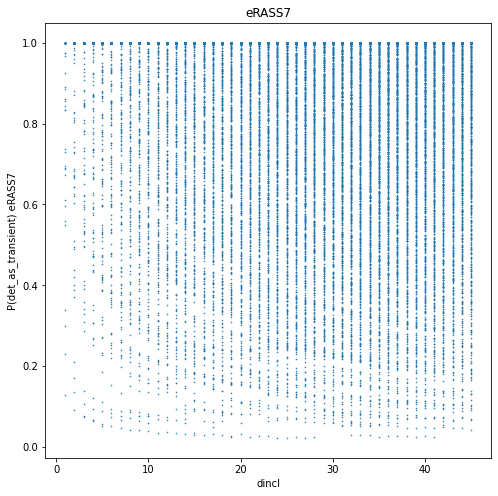

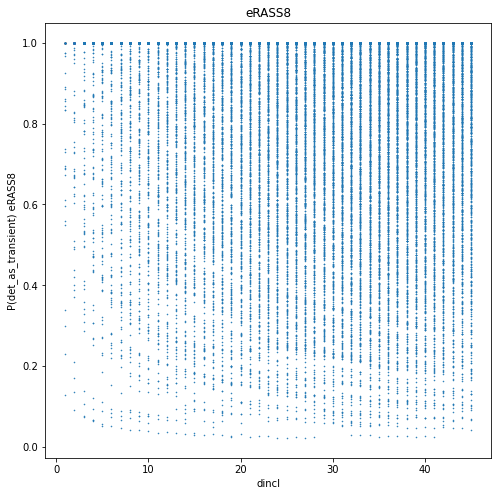

In [55]:

for col in erass_cols:
    plt.figure(figsize=(8,8))
    plt.title(col)
    plt.scatter(erass_sample['dincl'], erass_sample[col], s=0.3)
    plt.xlabel('dincl')
    plt.ylabel('P(det_as_transient) '+col)

In [56]:
sys27 = erass_sample[erass_sample['system_id'] == 27]

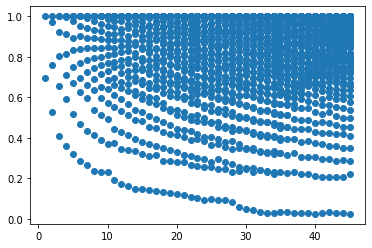

In [57]:
plt.scatter(sys27['dincl'], sys27['eRASS3'])

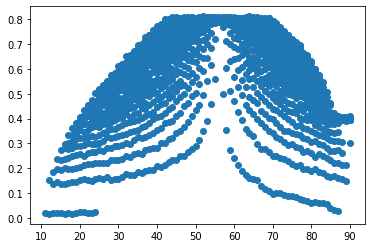

In [58]:
plt.scatter(sys27['inclination'], sys27['eRASS2'])

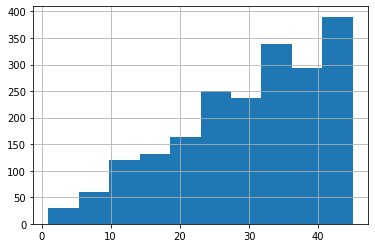

In [59]:
sys27['dincl'].hist()

/home/x1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


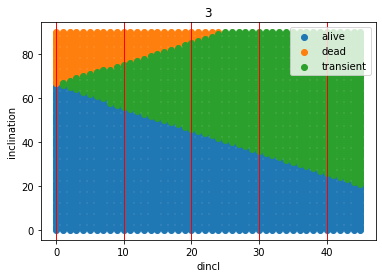

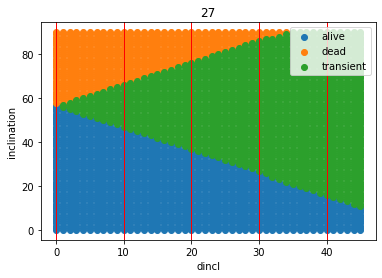

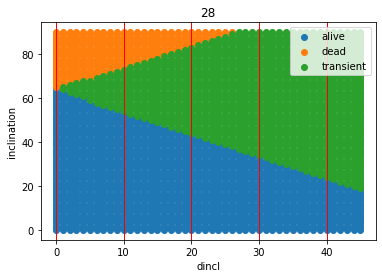

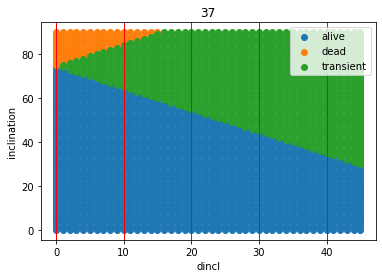

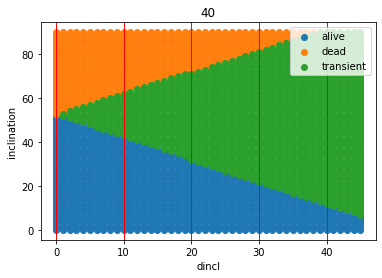

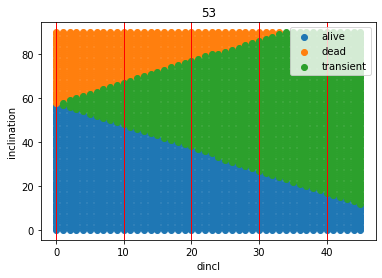

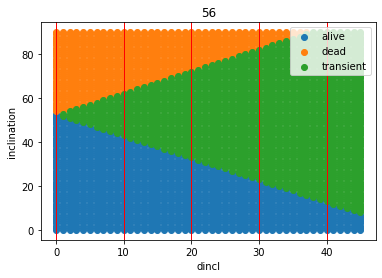

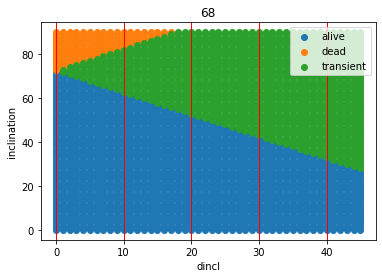

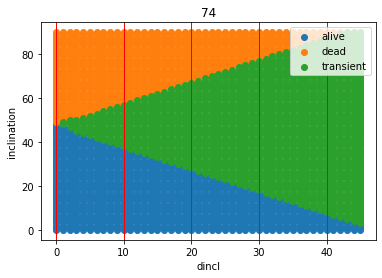

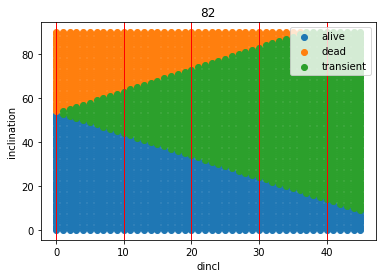

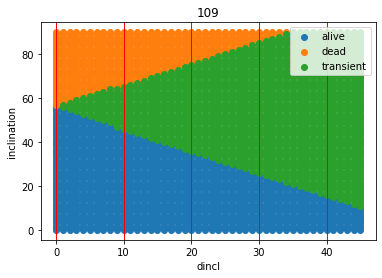

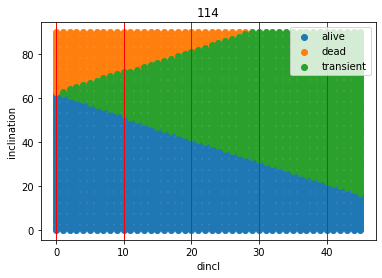

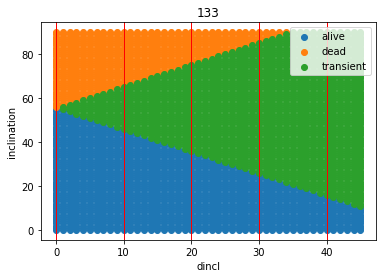

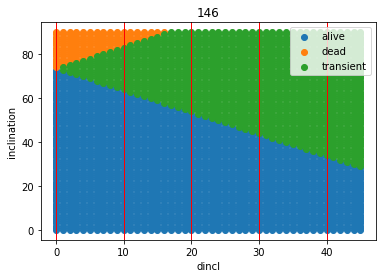

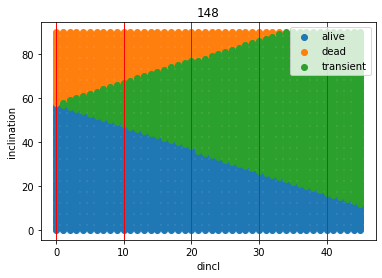

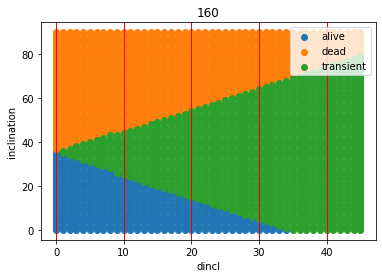

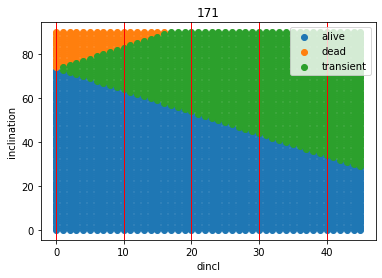

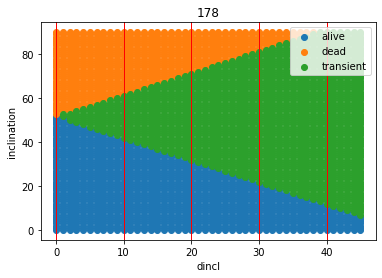

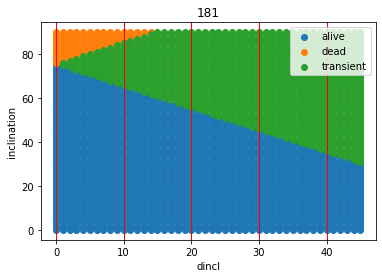

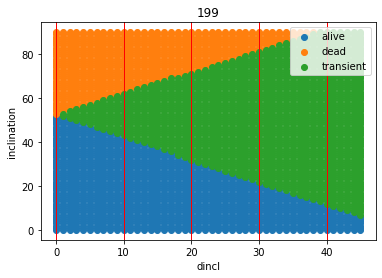

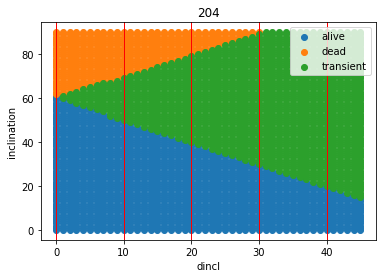

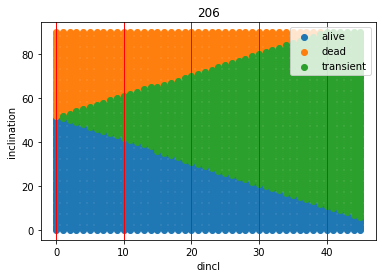

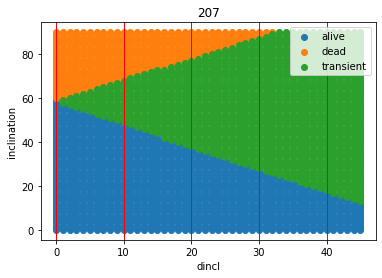

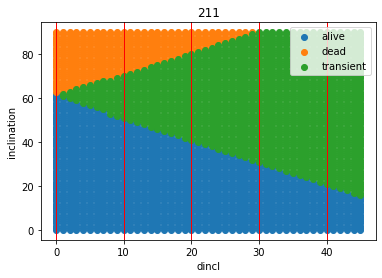

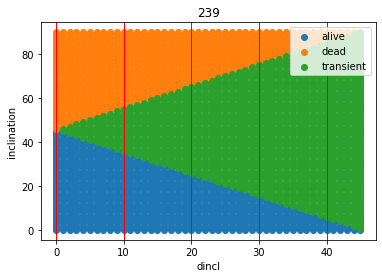

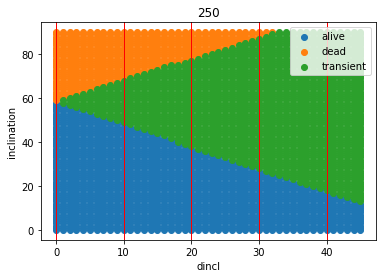

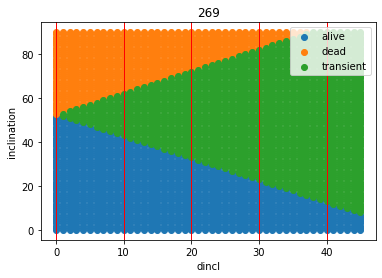

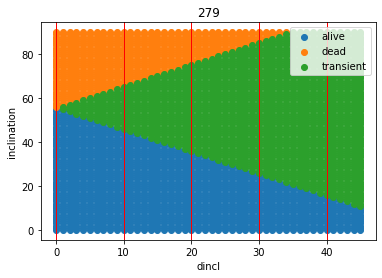

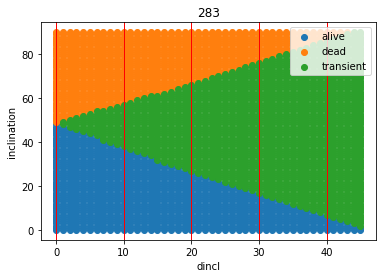

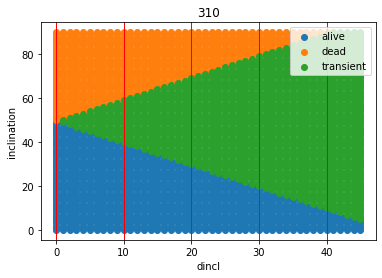

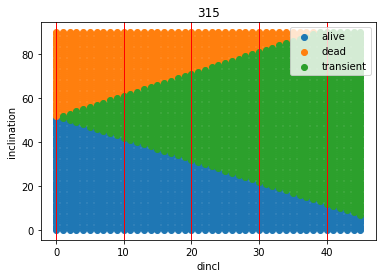

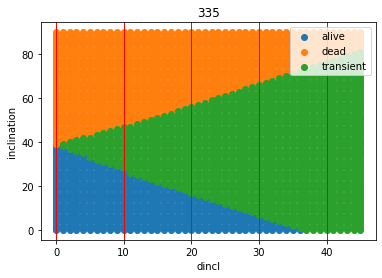

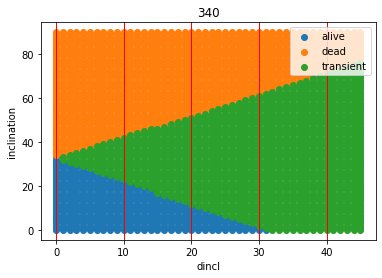

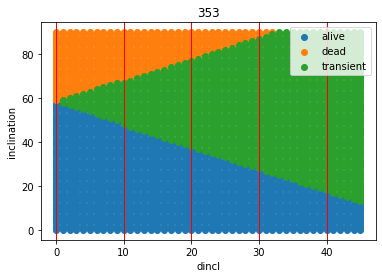

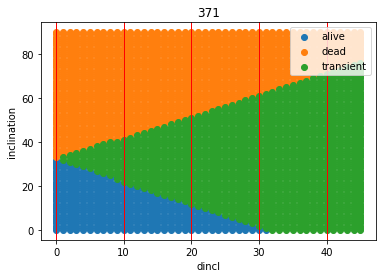

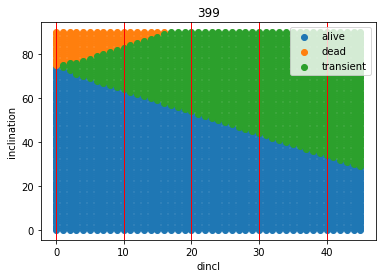

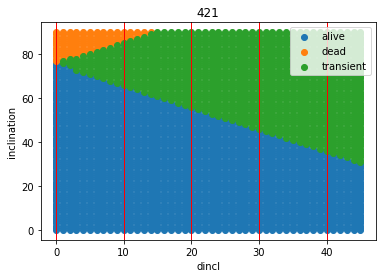

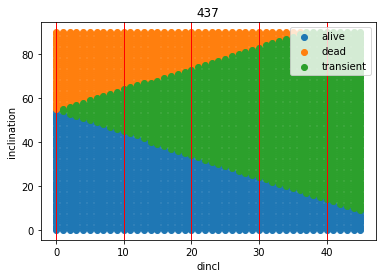

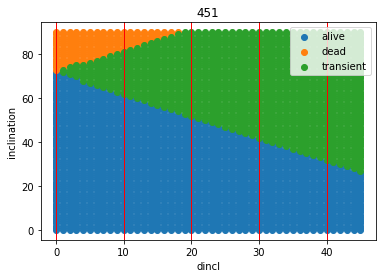

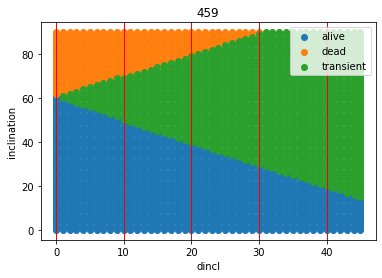

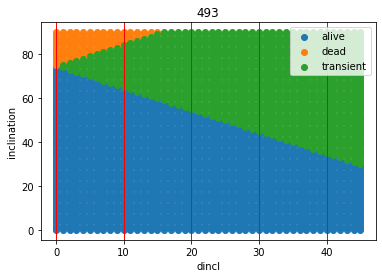

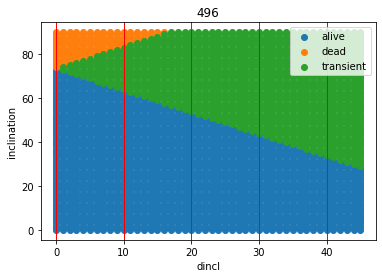

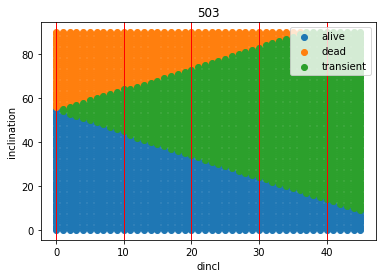

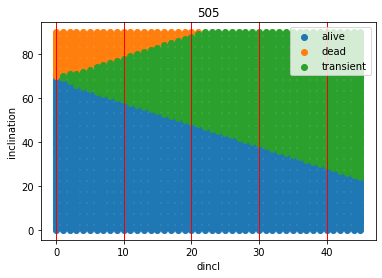

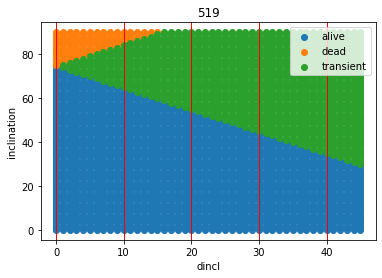

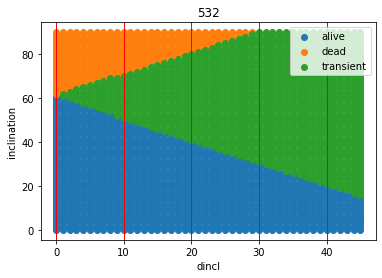

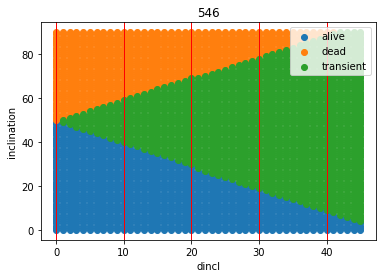

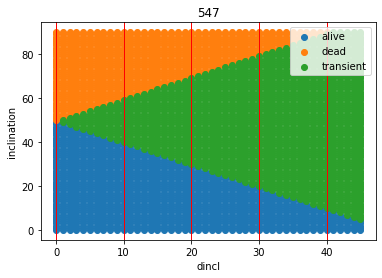

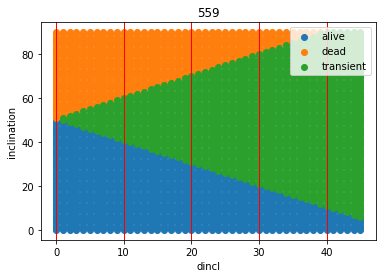

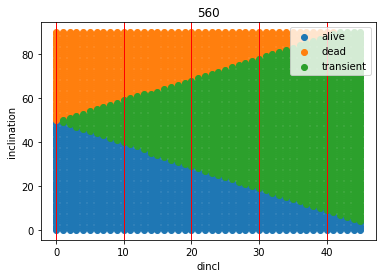

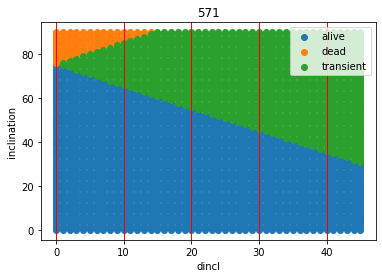

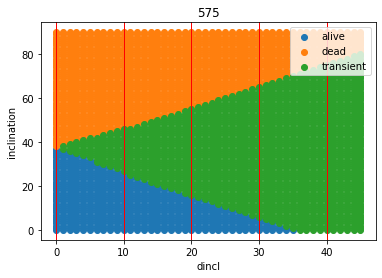

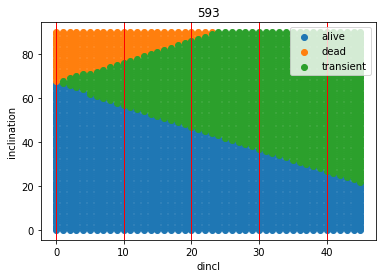

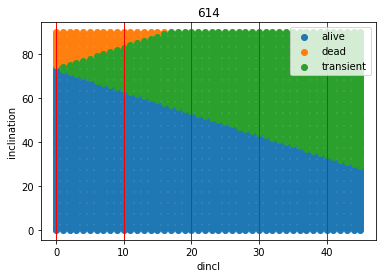

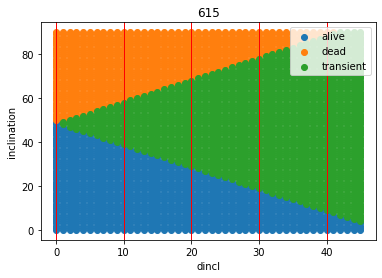

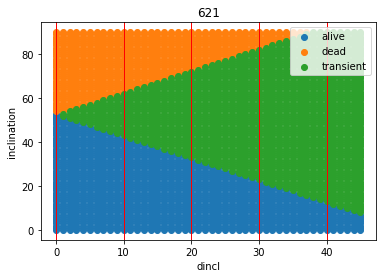

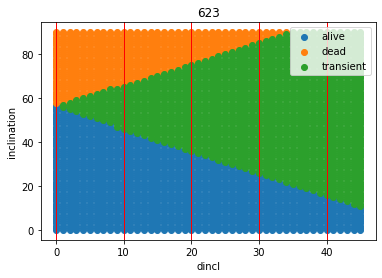

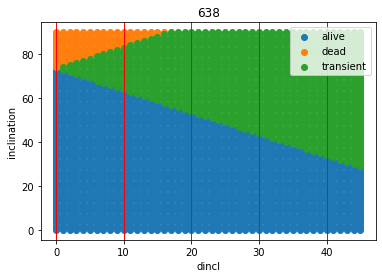

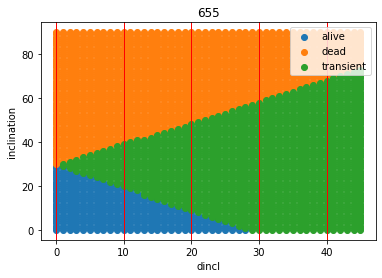

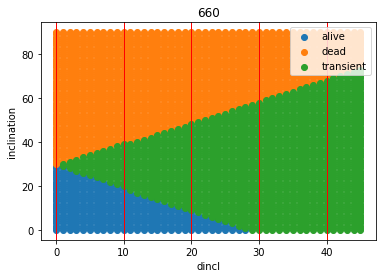

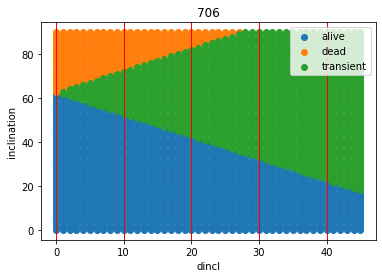

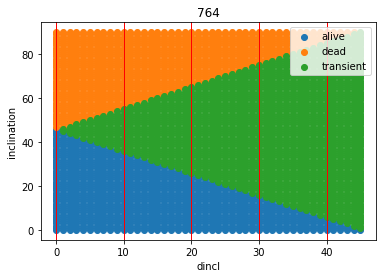

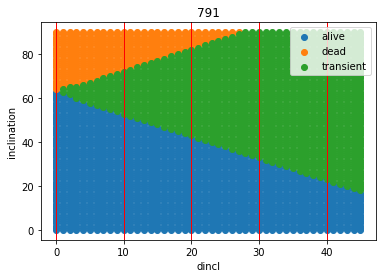

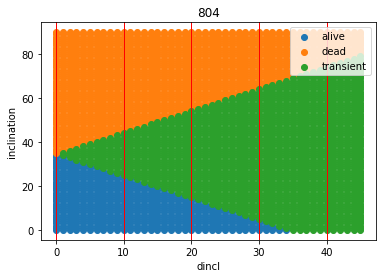

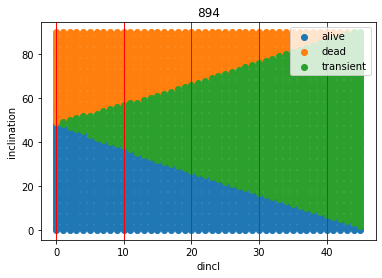

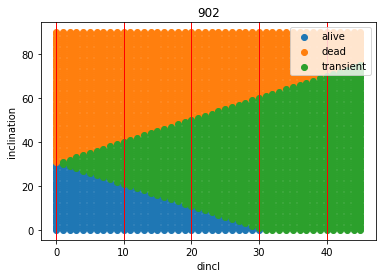

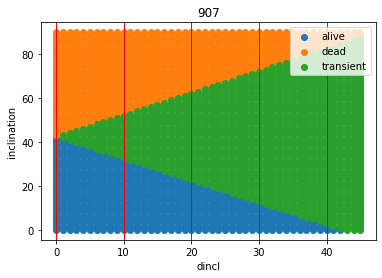

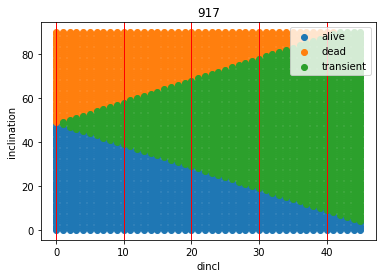

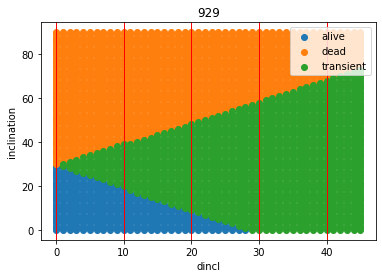

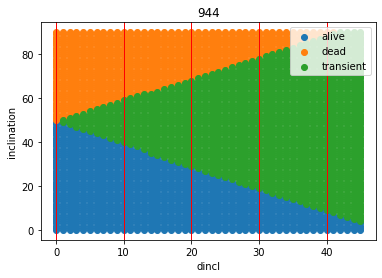

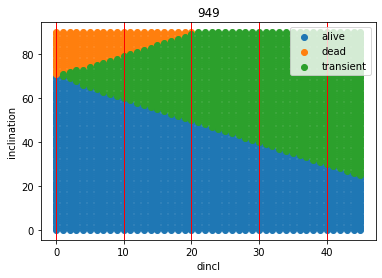

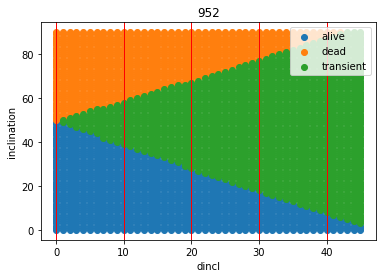

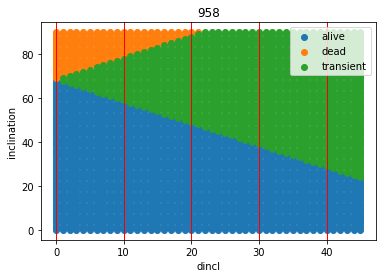

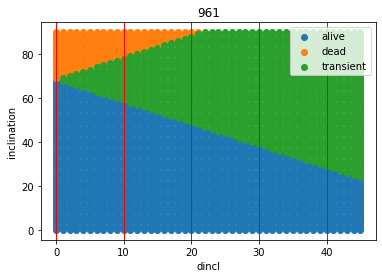

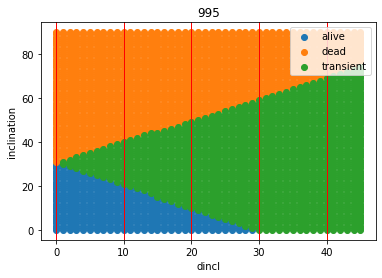

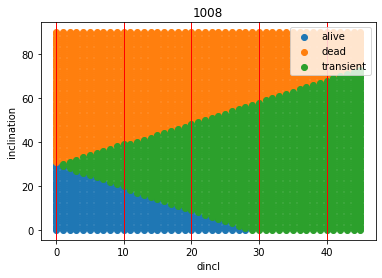

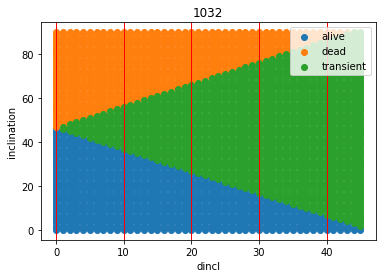

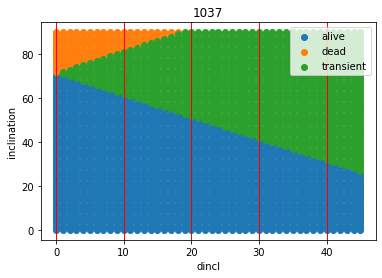

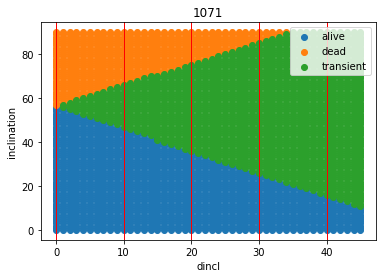

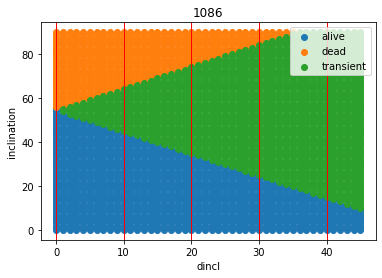

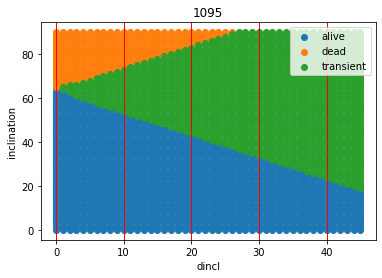

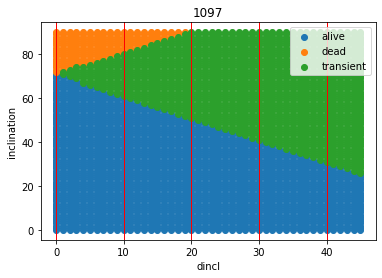

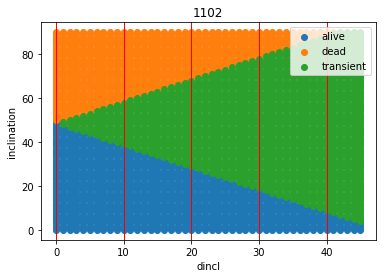

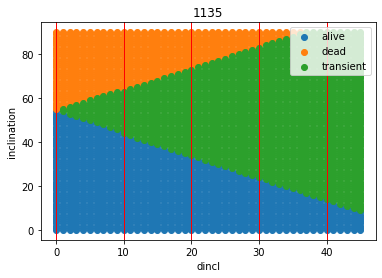

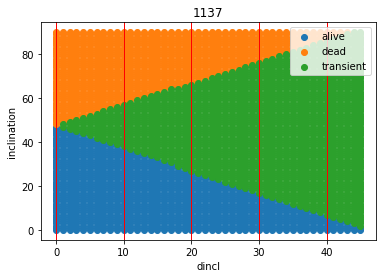

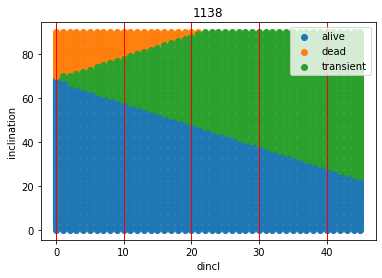

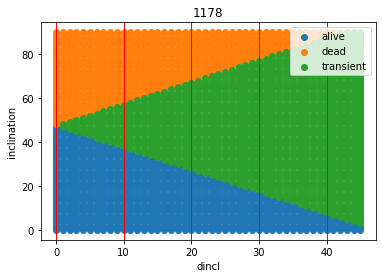

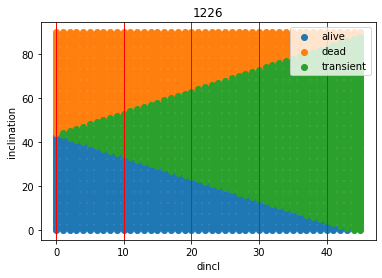

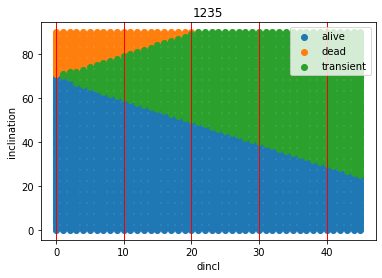

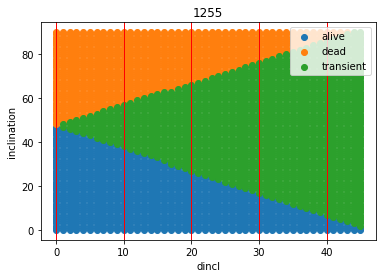

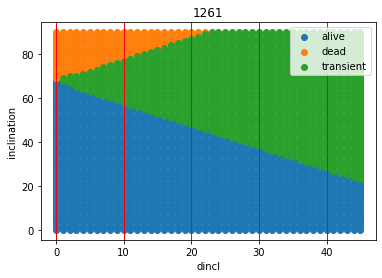

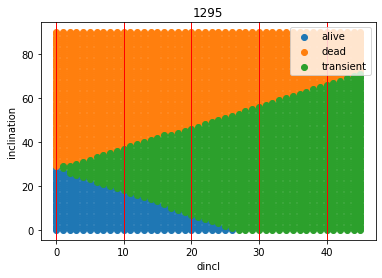

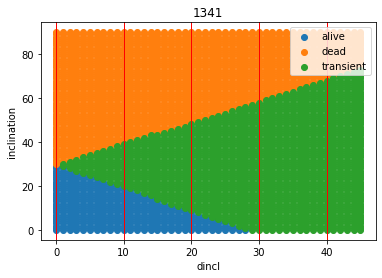

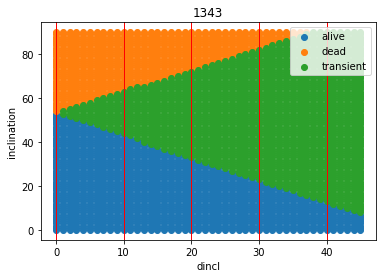

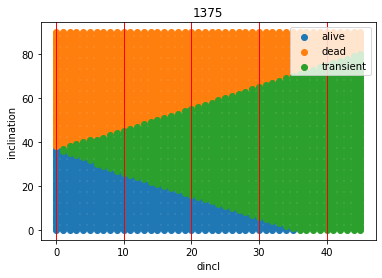

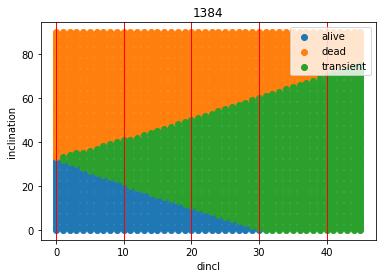

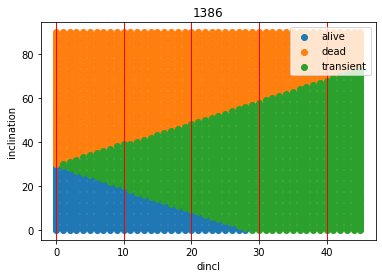

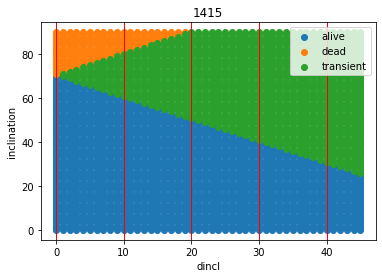

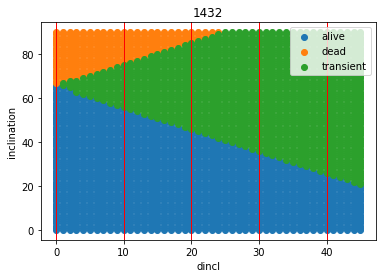

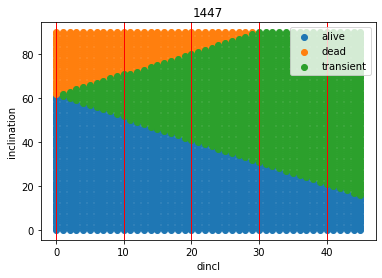

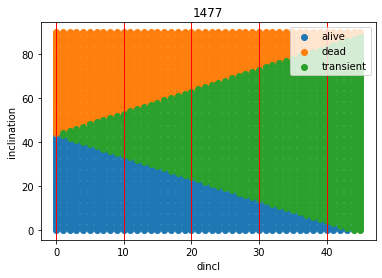

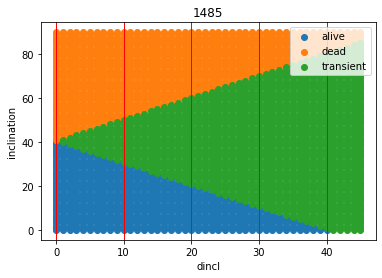

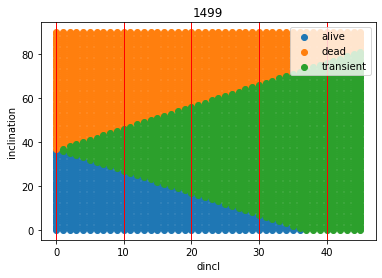

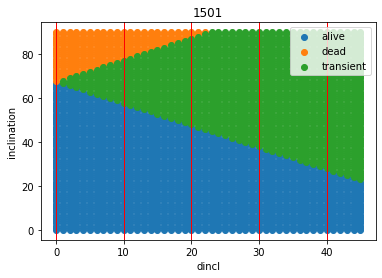

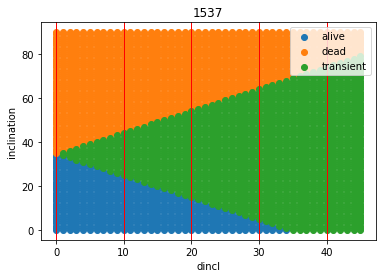

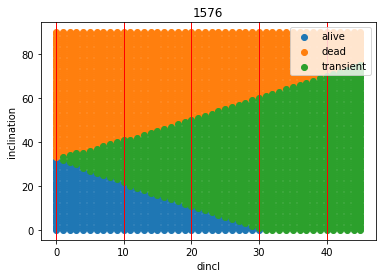

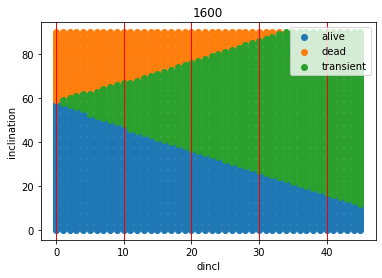

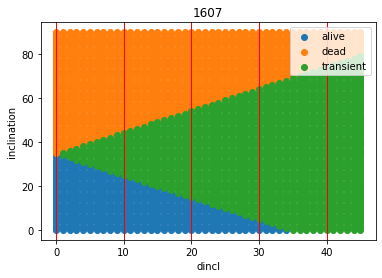

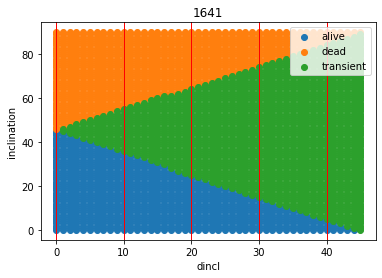

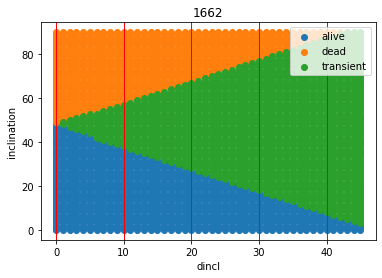

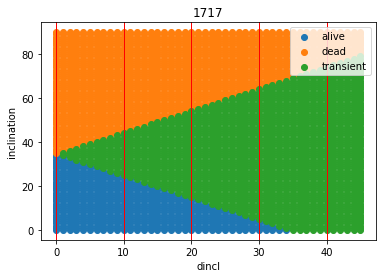

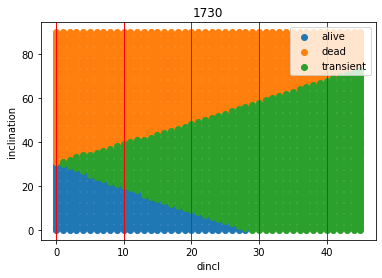

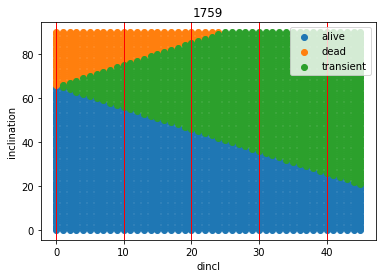

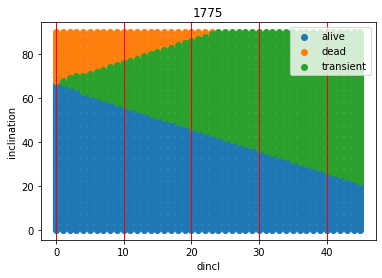

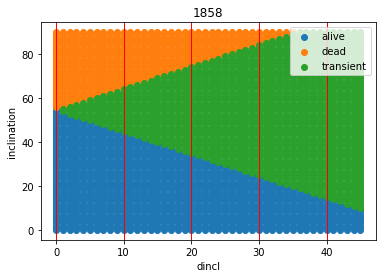

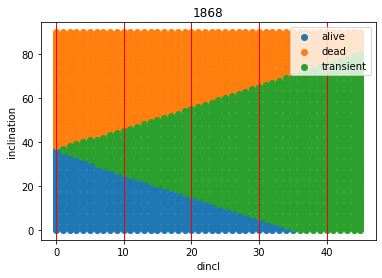

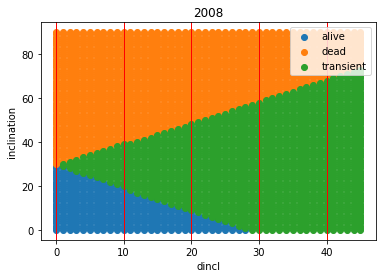

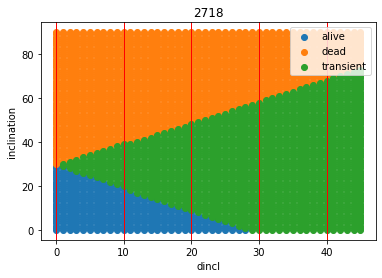

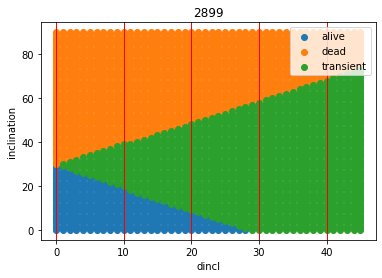

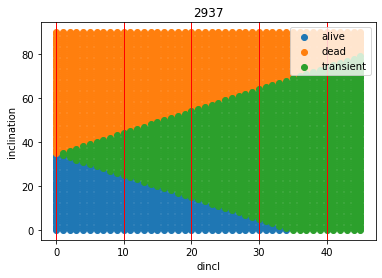

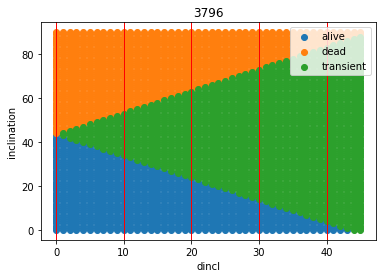

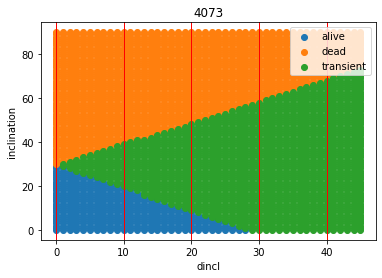

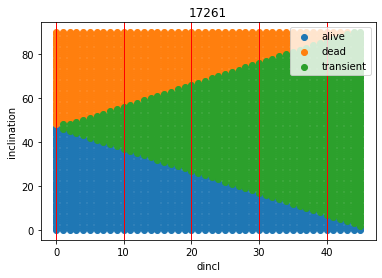

In [60]:
# Plot gridsearch of all the systems that we simulated curves for
for system_id in curve_classifications['system_id'].unique():
    plt.figure()
    plt.title(system_id)
    plt.xlabel('dincl')
    plt.ylabel('inclination')
    sys_cc = curve_classifications[curve_classifications['system_id'] == system_id]
    for c in sys_cc['classification'].unique():
        sub = sys_cc[sys_cc['classification'] == c]
        for x0 in [0,10,20,30,40]: plt.axvline(x=x0, c='r', linewidth=0.8)
            
        plt.scatter(sub['dincl'], sub['inclination'], label=c)
    plt.legend()

In [61]:
#For each system, count the number of classifications of each realisation
system_classification_count = pd.DataFrame()

for system_id in curve_classifications['system_id'].unique():
    sys_cc = curve_classifications[curve_classifications['system_id'] == system_id]
    system_classification_count = system_classification_count.append(sys_cc['classification'].value_counts().rename(system_id))

    
    
system_classification_count['total'] = system_classification_count['alive'] + system_classification_count['dead'] + system_classification_count['transient']
system_classification_count['P_alive'] = system_classification_count['alive'] / system_classification_count['total']
system_classification_count['P_dead'] = system_classification_count['dead'] / system_classification_count['total']
system_classification_count['P_transient'] = system_classification_count['transient'] / system_classification_count['total']


In [62]:
system_classification_count

alive    dead  transient   total   P_alive    P_dead  P_transient
3      2009.0   317.0     1860.0  4186.0  0.479933  0.075729     0.444338
27     1574.0   597.0     2015.0  4186.0  0.376015  0.142618     0.481366
28     1914.0   373.0     1899.0  4186.0  0.457238  0.089107     0.453655
37     2415.0   136.0     1635.0  4186.0  0.576923  0.032489     0.390588
40     1377.0   760.0     2049.0  4186.0  0.328954  0.181558     0.489489
...       ...     ...        ...     ...       ...       ...          ...
2899    446.0  1806.0     1934.0  4186.0  0.106546  0.431438     0.462016
2937    630.0  1541.0     2015.0  4186.0  0.150502  0.368132     0.481366
3796    990.0  1127.0     2069.0  4186.0  0.236503  0.269231     0.494267
4073    448.0  1804.0     1934.0  4186.0  0.107023  0.430960     0.462016
17261  1128.0   988.0     2070.0  4186.0  0.269470  0.236025     0.494505

[123 rows x 7 columns]

In [63]:
erass_sample

curve_id  eRASS1  eRASS2  eRASS3  eRASS4  eRASS5  eRASS6  eRASS7  \
0           4333     0.0  0.7977  1.0000  1.0000  1.0000  1.0000  1.0000   
1           4334     0.0  0.4984  0.6977  0.8489  1.0000  1.0000  1.0000   
2           4423     0.0  0.5610  0.7573  0.8767  1.0000  1.0000  1.0000   
3           4424     0.0  0.8002  1.0000  1.0000  1.0000  1.0000  1.0000   
4           4425     0.0  0.7668  0.9716  0.9872  1.0000  1.0000  1.0000   
...          ...     ...     ...     ...     ...     ...     ...     ...   
110452    506499     0.0  0.2759  0.4149  0.5583  0.6964  0.6964  0.6964   
110453    506500     0.0  0.2472  0.3718  0.4973  0.6238  0.6238  0.6238   
110454    506501     0.0  0.2021  0.3045  0.4086  0.5049  0.5049  0.5049   
110455    506502     0.0  0.1498  0.2261  0.3021  0.3811  0.3811  0.3811   
110456    506503     0.0  0.0729  0.1092  0.1463  0.1818  0.1818  0.1818   

        eRASS8  dincl  inclination  system_id  is_bh  
0       1.0000      1           56         27      1  
1       1.0000      1           57         27      1  
2       1.0000      2           55         27      1  
3       1.0000      2           56         27      1  
4       1.0000      2           57         27      1  
...        ...    ...          ...        ...    ...  
110452  0.6964     45           84       3796      0  
110453  0.6238     45           85       3796      0  
110454  0.5049     45           86       3796      0  
110455  0.3811     45           87       3796      0  
110456  0.1818     45           88       3796      0  

[110457 rows x 13 columns]

In [64]:
def filter_by_dincl(df, dincl):
    df_new = df[df['dincl'] < dincl]
    return df_new

def filter_by_system_id(df, system_id):
    df_new = df[df['system_id'] == system_id]
    return df_new

def plot_erass_curves(curve_classifications, erass_sample):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
    ax[0].set_title('only transients')
    ax[0].set_xlabel('eRASS cycle')
    ax[0].set_ylabel('number of transient detections')
    ax[1].set_xlabel('eRASS cycle')
    ax[1].set_ylabel('number of alive detections')
    ax[1].set_title('transients + alive')

    for dincl_cut in [45, 30, 15, 10, 5]:
        cc = filter_by_dincl(curve_classifications, dincl_cut)
        erass = filter_by_dincl(erass_sample, dincl_cut)

        for system_id in parent_population['system_id'].unique():
            sys_cc = filter_by_system_id(cc, system_id)
            sys_erass = filter_by_system_id(erass, system_id)

            sys_cc_alive = sys_cc[sys_cc['classification'] == 'alive']
            sys_cc_dead = sys_cc[sys_cc['classification'] == 'dead']
            sys_cc_transient = sys_cc[sys_cc['classification'] == 'transient']

            N_total = len(sys_cc)
            N_alive = len(sys_cc_alive)
            N_dead = len(sys_cc_dead)
            N_transient = len(sys_cc_transient)
    
            # ax[0].plot([1,2,3,4,5,6,7,8], (sys_erass[erass_cols].sum())/N_total, label=system_id)
            # ax[1].plot([1,2,3,4,5,6,7,8], (N_alive+sys_erass[erass_cols].sum())/N_total, label=system_id)
            
            ax[0].plot([1,2,3,4,5,6,7,8], (sys_erass[erass_cols].sum()), label=system_id)
            ax[1].plot([1,2,3,4,5,6,7,8], (N_alive+sys_erass[erass_cols].sum()), label=system_id)

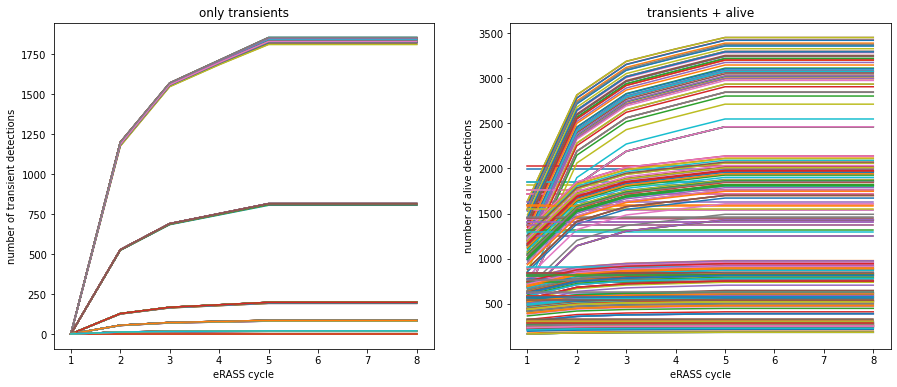

In [65]:
plot_erass_curves(curve_classifications, erass_sample)

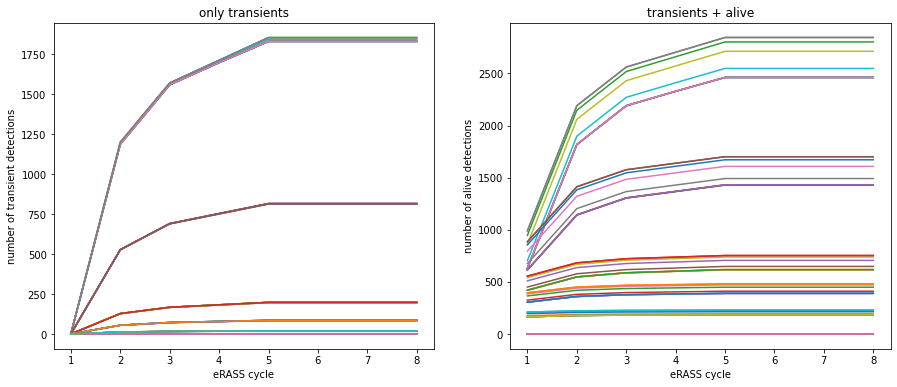

In [66]:
#NS ONLY
is_bh = False
cc = curve_classifications[curve_classifications['is_bh'] == is_bh]
erass = erass_sample[erass_sample['is_bh'] == is_bh ]
plot_erass_curves(cc, erass)

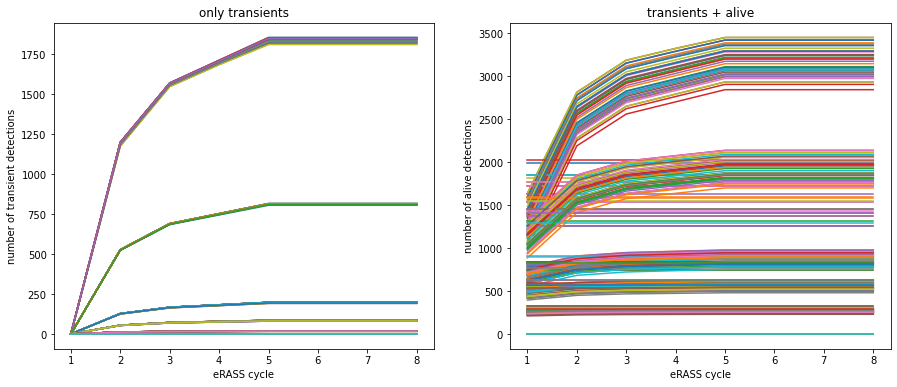

In [67]:
#BH ONLY
is_bh = True
cc = curve_classifications[curve_classifications['is_bh'] == is_bh]
erass = erass_sample[erass_sample['is_bh'] == is_bh ]
plot_erass_curves(cc, erass)

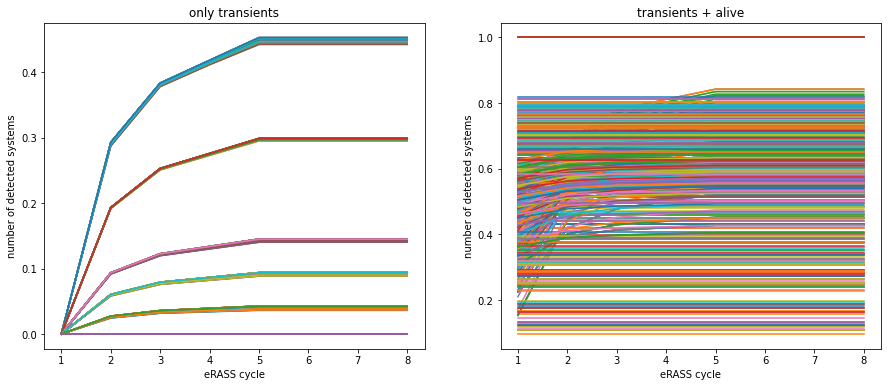

In [68]:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
    ax[0].set_title('only transients')
    ax[0].set_xlabel('eRASS cycle')
    ax[0].set_ylabel('number of detected systems')
    ax[1].set_xlabel('eRASS cycle')
    ax[1].set_ylabel('number of detected systems')
    ax[1].set_title('transients + alive')

    for dincl_cut in [45, 30, 15, 10, 5]:
        cc = filter_by_dincl(curve_classifications, dincl_cut)
        erass = filter_by_dincl(erass_sample, dincl_cut)

        for system_id in df_ulx.index.unique():
            sys_cc = filter_by_system_id(cc, system_id)
            sys_erass = filter_by_system_id(erass, system_id)

            sys_cc_alive = sys_cc[sys_cc['classification'] == 'alive']
            sys_cc_dead = sys_cc[sys_cc['classification'] == 'dead']
            sys_cc_transient = sys_cc[sys_cc['classification'] == 'transient']
            
            N_total = len(sys_cc)
            N_alive = len(sys_cc_alive)
            N_dead = len(sys_cc_dead)
            N_transient = len(sys_cc_transient)
            N_transient_erass = len(sys_erass)
            
            
            #print(f'{system_id} {N_total} {N_transient} {N_transient_erass}')
            if N_total == 0:
                ax[1].plot([1,2,3,4,5,6,7,8], [1,1,1,1,1,1,1,1], label=system_id)
            else:
                ax[0].plot([1,2,3,4,5,6,7,8], (sys_erass[erass_cols].sum())/N_total, label=system_id)
                ax[1].plot([1,2,3,4,5,6,7,8], (N_alive+sys_erass[erass_cols].sum())/N_total, label=system_id)

                
            #ax[0].plot([1,2,3,4,5,6,7,8], (sys_erass[erass_cols].sum()), label=system_id)
            #ax[1].plot([1,2,3,4,5,6,7,8], (N_alive+sys_erass[erass_cols].sum()), label=system_id)

1.  Take total population of 920 ULXs, mix of BHs/NSs
2.	create fake parent population of 500 ULXs of given BH/NS ratio
3.	Determine how many are always on/always dead from non-beamed
4.	from beamed, draw over eRASS and determine how the number of transients increase over time
5.	Gives us alive vs transient (as function of total population demographic)
6.	Repeat for new realisations up to ~1000
7.	Repeat for dinc cut
8.	Repeat 1-7 for new BH/NS ratio


In [69]:
def create_keys(selected_systems, selected_dincls, selected_inclinations,):
    a = np.core.defchararray.add(selected_systems.astype(str), '-')
    b = np.core.defchararray.add(selected_dincls.astype(str), '-')
    keys = np.core.defchararray.add(a,b)
    keys = np.core.defchararray.add(keys,selected_inclinations.astype(str))
    return keys

In [70]:
def sample_by_bh_ratio(systems_df, bh_ratio, n):
    ns_ratio = 1 - bh_ratio
    
    ns_systems = systems_df[systems_df['is_bh']==0].index
    bh_systems = systems_df[systems_df['is_bh']==1].index
    
    bh_weights = [bh_ratio/len(bh_systems)]*len(bh_systems)
    ns_weights = [ns_ratio/len(ns_systems)]*len(ns_systems)
    selected_systems = np.random.choice([*bh_systems, *ns_systems], size=n, p=[*bh_weights, *ns_weights])
    return selected_systems

In [71]:
def create_classification_dict():
    # Classication dict
    keys = (curve_classifications['system_id'].astype(str) +
            '-' + curve_classifications['dincl'].astype(str) +
            '-' + curve_classifications['inclination'].astype(str)).values
    classications = curve_classifications['classification'].values
    class_dict = dict(zip(keys,classications))
    return class_dict

class_dict = create_classification_dict()

In [72]:
def is_ulx_on_first_cycle():
    probability_above = 0.5
    # print(f'Checking ULX or not on cycle 1, prob_above: {probability_above:.2f}')
    r = np.random.random()
    if r < probability_above:
        above = True
    else:
        above = False
    
    # print(f'ulx_on_first_cycle: {above}')    
    return above

In [73]:
t0 = time.time()

sample_size = 500
bh_ratio = 0.5



selected_systems       = sample_by_bh_ratio(df_ulx, bh_ratio, sample_size)
selected_dincls        = np.random.randint(0,46, size=sample_size)
selected_inclinations  = np.random.randint(0,91, size=sample_size)
selected_keys          = create_keys(selected_systems, selected_dincls, selected_inclinations)
selected_classications = [class_dict.get(key) for key in selected_keys]


N_total     = sample_size
N_alive     = selected_classications.count('alive') + selected_classications.count(None) #None --> no lightcurve --> alive
N_transient = selected_classications.count('transient')
N_dead      = selected_classications.count('dead')

if N_alive + N_transient + N_dead != N_total:
    print('sum of classifications != number of inputs')


    
N_alive_persisitent = 0
N_dead_persisitent  = 0
N_transient_erass   = [0] * 8
N_alive_erass       = [0] * 8
N_dead_erass        = [0] * 8

for i in range(sample_size):
    print(f'===============================')
    print(f'System_index = \t\t {i}, ')
    print(f'System_id = \t\t {selected_systems[i]}, ')
    print(f'System_dincl = \t\t {selected_dincls[i]}, ')
    print(f'System_inclination = \t {selected_inclinations[i]}, ')
    print(f'System_classification =\t {selected_classications[i]}')
    print('-------------------------------')
    
    classification = selected_classications[i]
    if classification == None:
        print('SYSTEM ALIVE | No curve found')
        #No curve --> Alive
        N_alive_persisitent += 1

    if classification == 'alive':
        print('SYSTEM ALIVE | persistent curve found')
        N_alive_persisitent+=1

    if classification == 'dead':
        print('SYSTEM DEAD | persistent curve found')
        N_dead_persisitent+=1

    if classification == 'transient':
        print('FOUND TRANSIENT SYSTEM')
        sys_id = selected_systems[i]
        dincl = selected_dincls[i]
        inclination = selected_inclinations[i]

        system_erass =  erass_sample[(erass_sample['system_id'] == sys_id)
                     & (erass_sample['dincl'] == dincl)
                     & (erass_sample['inclination'] == inclination)]

        if len(system_erass) == 0:
            print(f'No found eRASS simulations | P_wind > 4 years')
            print('Treating as persistent over eRASS length')
            
            ulx_first_cycle = is_ulx_on_first_cycle()
            
            if ulx_first_cycle:
                print('SYSTEM ALIVE | (no eRASS sims) | P_WIND > 4 years')
                N_alive_persisitent += 1
            else:
                print('SYSTEM DEAD | (no eRASS sims) | P_WIND > 4 years')
                N_dead_persisitent += 1

        else:
            print('Found eRASS simulations')

            # 0 : alive   1 : dead
            ulx_first_cycle = is_ulx_on_first_cycle()

                    

            prob_erass_transient_detection = np.array(system_erass[erass_cols])[0]
            print(prob_erass_transient_detection)

            #get_erass_alive_dead_evolution(prob_erass_transient_detection)
            detected_as_transient = False
            for erass_cycle_index, prob_transient in enumerate(erass_probabilities):
                if detected_as_transient:
                    print(f'cycle_index = {erass_cycle_index} / 7 | previously detected as transient')
                    N_transient_erass[erass_cycle_index] += 1
                    continue
                
                print(f'cycle_index = {erass_cycle_index} / 7 | rolling if transient')
                rand = np.random.random()
                print(f'roll: {rand:.2f} prob_transient: {prob_transient}')

                if rand <= prob_transient:
                    print(f'cycle_index = {erass_cycle_index} / 7 | Detected as transient')
                    detected_as_transient = True
                    N_transient_erass[erass_cycle_index] += 1
                    
                else:
                    print(f'cycle_index = {erass_cycle_index} / 7 | not transient')
                    if ulx_first_cycle:
                        N_alive_erass[erass_cycle_index] += 1
                    else:
                        N_dead_erass[erass_cycle_index] += 1
                        
            
            if detected_as_transient == False:
                if ulx_first_cycle:
                    print('SYSTEM ALIVE | persistent over erass length')
                    N_alive_persisitent+=1
                else:
                    print('SYSTEM DEAD | persistent over erass length')
                    N_dead_persisitent+=1
                        
    
    print('-------------------------------')
    print(f'Running tally:')
    print(f'Persistent alive =\t{N_alive_persisitent}')
    print(f'Persistent dead =\t{N_dead_persisitent}')
    print(f'eRASS_alive \t = {N_alive_erass}')
    print(f'eRASS_transient\t = {N_transient_erass}')
    print(f'eRASS_dead \t = {N_dead_erass}')
    
    print(f'===============================')
    print('')
    
plt.scatter([1,2,3,4,5,6,7,8], N_transient_erass)
plt.scatter([1,2,3,4,5,6,7,8], N_alive_erass)
plt.scatter([1,2,3,4,5,6,7,8], N_dead_erass)


print('time taken:',  time.time() - t0)
    

System_index = 		 0, 
System_id = 		 929, 
System_dincl = 		 27, 
System_inclination = 	 85, 
System_classification =	 dead
-------------------------------
SYSTEM DEAD | persistent curve found
-------------------------------
Running tally:
Persistent alive =	0
Persistent dead =	1
eRASS_alive 	 = [0, 0, 0, 0, 0, 0, 0, 0]
eRASS_transient	 = [0, 0, 0, 0, 0, 0, 0, 0]
eRASS_dead 	 = [0, 0, 0, 0, 0, 0, 0, 0]

System_index = 		 1, 
System_id = 		 549, 
System_dincl = 		 31, 
System_inclination = 	 54, 
System_classification =	 None
-------------------------------
SYSTEM ALIVE | No curve found
-------------------------------
Running tally:
Persistent alive =	1
Persistent dead =	1
eRASS_alive 	 = [0, 0, 0, 0, 0, 0, 0, 0]
eRASS_transient	 = [0, 0, 0, 0, 0, 0, 0, 0]
eRASS_dead 	 = [0, 0, 0, 0, 0, 0, 0, 0]

System_index = 		 2, 
System_id = 		 3454, 
System_dincl = 		 36, 
System_inclination = 	 26, 
System_classification =	 None
-------------------------------
SYSTEM ALIVE | No curve found
------

NameError: name 'erass_probabilities' is not defined

In [ ]:
def run(sample_size=500, bh_ratio=0.5, dincl_cut=46):
    selected_systems       = sample_by_bh_ratio(df_ulx, bh_ratio, sample_size)
    selected_dincls        = np.random.randint(0, dincl_cut, size=sample_size)
    selected_inclinations  = np.random.randint(0,91, size=sample_size)
    selected_keys          = create_keys(selected_systems, selected_dincls, selected_inclinations)
    selected_classications = [class_dict.get(key) for key in selected_keys]


    N_total     = sample_size
    N_alive     = selected_classications.count('alive') + selected_classications.count(None) #None --> no lightcurve --> alive
    N_transient = selected_classications.count('transient')
    N_dead      = selected_classications.count('dead')

    if N_alive + N_transient + N_dead != N_total:
        print('sum of classifications != number of inputs')



    N_alive_persisitent = 0
    N_dead_persisitent  = 0
    N_transient_erass   = [0] * 8
    N_alive_erass       = [0] * 8
    N_dead_erass        = [0] * 8

    for i in range(sample_size):
        classification = selected_classications[i]
        if classification == None:
            #No curve --> Alive
            N_alive_persisitent += 1

        if classification == 'alive':
            N_alive_persisitent+=1

        if classification == 'dead':
            N_dead_persisitent+=1

        if classification == 'transient':
            sys_id = selected_systems[i]
            dincl = selected_dincls[i]
            inclination = selected_inclinations[i]

            system_erass =  erass_sample[(erass_sample['system_id'] == sys_id)
                         & (erass_sample['dincl'] == dincl)
                         & (erass_sample['inclination'] == inclination)]

            if len(system_erass) == 0:
                ulx_first_cycle = is_ulx_on_first_cycle()

                if ulx_first_cycle:
                    N_alive_persisitent += 1
                else:
                    N_dead_persisitent += 1

            else:
                # 0 : alive   1 : dead
                ulx_first_cycle = is_ulx_on_first_cycle()
                prob_erass_transient_detection = np.array(system_erass[erass_cols])[0]

                #get_erass_alive_dead_evolution(prob_erass_transient_detection)
                detected_as_transient = False
                for erass_cycle_index, prob_transient in enumerate(prob_erass_transient_detection):
                    if detected_as_transient:
                        N_transient_erass[erass_cycle_index] += 1
                        continue

                    rand = np.random.random()

                    if rand <= prob_transient:
                        detected_as_transient = True
                        N_transient_erass[erass_cycle_index] += 1

                    else:
                        if ulx_first_cycle:
                            N_alive_erass[erass_cycle_index] += 1
                        else:
                            N_dead_erass[erass_cycle_index] += 1


                if detected_as_transient == False:
                    if ulx_first_cycle:
                        N_alive_persisitent+=1
                    else:
                        N_dead_persisitent+=1
                        
    return N_alive_persisitent, N_dead_persisitent, N_alive_erass, N_transient_erass, N_dead_erass

In [ ]:
import itertools

dincls = [46, 40, 30, 20, 10]
bh_ratios = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
repeats = np.arange(100)

results = {}
for i, variables in enumerate(itertools.product(dincls, bh_ratios, repeats)):
    print(i)
    dincl, bh, repeat = variables
    N_alive_persisitent, N_dead_persisitent, N_alive_erass, N_transient_erass, N_dead_erass = run(sample_size=500, bh_ratio=bh, dincl_cut=dincl)
    results[i] =( dincl,
                  bh,
                  repeat,
                  N_alive_persisitent,
                  N_dead_persisitent,
                  N_alive_erass,
                  N_transient_erass,
                  N_dead_erass)
    
    

In [ ]:
res = pd.DataFrame(results)
res = res.T
res.columns = ['dincl', 'bh', 'repeat', 'N_alive_persisitent', 'N_dead_persisitent', 'N_alive_erass', 'N_transient_erass', 'N_dead_erass'


In [ ]:
res.to_csv('../data/interim/erass_sim_alive_dead.csv')

In [ ]:
res

In [ ]:
for dincl in res['dincl'].unique():
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    ax[0].set_ylabel('N_transient_erass')
    ax[0].set_xlabel('eRASS cycle')
    ax[0].set_title(f'dincl={dincl}')
    ax[0].set_ylim(0,80)
    ax[1].set_ylim(0,80)
    
    sub = res[res['dincl'] == dincl]
    N_transient_erass = col2arr(sub, 'N_transient_erass')
    
    mean = np.mean(N_transient_erass, axis=0)
    maximum  = np.max(N_transient_erass, axis=0)
    
    ax[1].plot(mean, c='blue', linestyle='-', label='mean')
    ax[1].plot(maximum, c='green', linestyle='--', label='max')
    ax[1].legend()
    for i, row in sub.iterrows():
        ax[0].plot(row['N_transient_erass'])

In [ ]:
for bh in res['bh'].unique():
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    ax[0].set_ylabel('N_transient_erass')
    ax[0].set_xlabel('eRASS cycle')
    ax[0].set_title(f'bh_percent={bh}')
    ax[0].set_ylim(0,80)
    ax[1].set_ylim(0,80)
    
    sub = res[res['bh'] == bh]
    mean = np.mean(np.array(list(sub['N_transient_erass'])), axis=0)
    maximum  = np.max(np.array(list(sub['N_transient_erass'])), axis=0)
    
    ax[1].plot(mean, c='blue', linestyle='-', label='mean')
    ax[1].plot(maximum, c='green', linestyle='--', label='max')
    ax[1].legend()
    for i, row in sub.iterrows():
        ax[0].plot(row['N_transient_erass'])

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].set_xlabel('bh_percent')
ax[0].set_ylabel('Number of systems')
ax[0].scatter(res['bh'], res['N_alive_persisitent'], label='Alive persistent')
ax[0].scatter(res['bh'], res['N_dead_persisitent'], label='Dead persistent')
ax[0].legend()


ax[1].set_xlabel('dincl')
ax[1].set_ylabel('Number of systems')
ax[1].scatter(res['dincl'], res['N_alive_persisitent'], label='Alive persistent')
ax[1].scatter(res['dincl'], res['N_dead_persisitent'], label='Dead persistent')
ax[1].legend()


In [ ]:
#eRASS transients alive/dead evolution
plt.figure(figsize=(10,8))
plt.xlabel('eRASS cycle')
plt.ylabel('Number of systems')
for i, row in res.iterrows():
    plt.plot(row['N_transient_erass'], c='orange', linewidth=0.8)
    plt.plot(row['N_alive_erass'], c='green', linewidth=0.8)
    plt.plot(row['N_dead_erass'], c='red', linewidth=0.8)

In [ ]:
#eRASS transients alive/dead evolution
for bh in res['bh'].unique():
    plt.figure(figsize=(6,4))
    plt.title(f'BH_PERCENT = {str(bh*100)}')
    plt.xlabel('eRASS cycle')
    plt.ylabel('Number of systems')
    plt.ylim(0,60)
    for dincl in res['dincl'].unique():    
        sub = res[(res['dincl'] == dincl) & (res['bh'] == bh)]   
        
        trans_means = np.array([np.array(x) for x in sub['N_transient_erass'].values]).mean(axis=0)
        alive_means = np.array([np.array(x) for x in sub['N_alive_erass'].values]).mean(axis=0)
        dead_means = np.array([np.array(x) for x in sub['N_dead_erass'].values]).mean(axis=0)
        
        plt.plot(trans_means, label=dincl)
        plt.plot(alive_means)
        plt.plot(dead_means)
    plt.savefig(f'../reports/figures/eRASS/transients_by_dincl_bh={bh}.png')
    plt.savefig(f'../reports/figures/eRASS/transients_by_dincl_dincl={bh}.eps')
    plt.savefig(f'../reports/figures/eRASS/transients_by_dincl_dincl={bh}.pdf')
    plt.legend()

In [ ]:
#eRASS transients alive/dead evolution
for dincl in res['dincl'].unique():
    plt.figure(figsize=(6,4))
    plt.title(str(dincl))
    plt.xlabel('eRASS cycle')
    plt.ylabel('Number of systems')
    plt.ylim(0,60)
    

    for bh in res['bh'].unique():
        sub = res[(res['dincl'] == dincl) & (res['bh'] == bh)]   
        trans_means = np.array([np.array(x) for x in sub['N_transient_erass'].values]).mean(axis=0)
        alive_means = np.array([np.array(x) for x in sub['N_alive_erass'].values]).mean(axis=0)
        dead_means = np.array([np.array(x) for x in sub['N_dead_erass'].values]).mean(axis=0)
        plt.plot(trans_means, label=bh)
        plt.plot(alive_means)
        plt.plot(dead_means)
    plt.legend()
    #plt.savefig(f'../reports/figures/eRASS/transients_by_bh_dincl={dincl}.png')
    #plt.savefig(f'../reports/figures/eRASS/transients_by_bh_dincl={dincl}.eps')
    #plt.savefig(f'../reports/figures/eRASS/transients_by_bh_dincl={dincl}.pdf')

In [ ]:
for dincl in res['dincl'].unique():
    plt.figure(figsize=(6,4))
    plt.title(str(dincl))
    plt.xlabel('eRASS cycle')
    plt.ylabel('Transient to persistent alive %')
    

    for bh in res['bh'].unique():
        sub = res[(res['dincl'] == dincl) & (res['bh'] == bh)]   
        
        persistent_alive_mean = sub['N_alive_persisitent'].mean()
        persistent_dead_mean = sub['N_dead_persisitent'].mean()
        
        trans_means = np.array([np.array(x) for x in sub['N_transient_erass'].values]).mean(axis=0)
        alive_means = np.array([np.array(x) for x in sub['N_alive_erass'].values]).mean(axis=0)
        dead_means = np.array([np.array(x) for x in sub['N_dead_erass'].values]).mean(axis=0)
        

        plt.plot(np.arange(1,9), trans_means/persistent_alive_mean*100, label=bh)
    plt.legend()
    #plt.savefig(f'../reports/figures/eRASS/transients_by_bh_dincl={dincl}.png')
    #plt.savefig(f'../reports/figures/eRASS/transients_by_bh_dincl={dincl}.eps')
    #plt.savefig(f'../reports/figures/eRASS/transients_by_bh_dincl={dincl}.pdf')

In [ ]:
#eRASS transients alive/dead evolution
for bh in res['bh'].unique():
    plt.figure(figsize=(6,4))
    plt.title(f'BH % = {str(bh*100)}')
    plt.xlabel('eRASS cycle')
    plt.ylabel('Transient to persistent alive %')
    for dincl in res['dincl'].unique():    
        sub = res[(res['dincl'] == dincl) & (res['bh'] == bh)]   
        
        persistent_alive_mean = sub['N_alive_persisitent'].mean()
        persistent_dead_mean = sub['N_dead_persisitent'].mean()
        
        trans_means = np.array([np.array(x) for x in sub['N_transient_erass'].values]).mean(axis=0)
        alive_means = np.array([np.array(x) for x in sub['N_alive_erass'].values]).mean(axis=0)
        dead_means = np.array([np.array(x) for x in sub['N_dead_erass'].values]).mean(axis=0)
        
        plt.plot(np.arange(1,9), trans_means/persistent_alive_mean*100, label=label=f'$\Delta i$ < {dincl}')
    #plt.savefig(f'../reports/figures/eRASS/transients_by_dincl_bh={bh}.png')
    #plt.savefig(f'../reports/figures/eRASS/transients_by_dincl_dincl={bh}.eps')
    #plt.savefig(f'../reports/figures/eRASS/transients_by_dincl_dincl={bh}.pdf')
    plt.legend()

In [ ]:
def calc_diff(arr):
    diff = np.diff(arr, prepend=[np.NaN])
    return diff

In [ ]:
N_trans = col2arr(res, 'N_transient_erass')
N_trans

In [ ]:
for bh in res['bh'].unique():
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].set_title(f'BH % = {str(bh*100)}')
    ax[1].set_title(f'BH % = {str(bh*100)}')
    ax[0].set_ylim(0,60)
    ax[1].set_ylim(0,60)
    
    ax[0].set_ylabel('# of new transient found in cycle')
    ax[0].set_xlabel('erass_cycle')
    ax[1].set_xlabel('erass_cycle')
    
    
    sub = res[(res['bh'] == bh)]   
    N_trans = col2arr(sub, 'N_transient_erass')
    diff = np.diff(N_trans)
    
    mean = np.mean(diff, axis=0)
    maximum = np.max(diff, axis=0)
    ax[1].plot(np.arange(2,9), mean, label='mean')
    ax[1].plot(np.arange(2,9), maximum, label='max')
    ax[1].legend()
    
    for i in diff:
        ax[0].plot(np.arange(2,9), i)

In [ ]:
for dincl in res['dincl'].unique():
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].set_title(f'dincl cut = {dincl}')
    ax[1].set_title(f'dincl cut = {dincl}')
    ax[0].set_ylim(0,60)
    ax[1].set_ylim(0,60)
    
    ax[0].set_ylabel('# of new transient found in cycle')
    ax[0].set_xlabel('erass_cycle')
    ax[1].set_xlabel('erass_cycle')
    
    
    sub = res[(res['dincl'] == dincl)]   
    N_trans = col2arr(sub, 'N_transient_erass')
    diff = np.diff(N_trans)
    
    mean = np.mean(diff, axis=0)
    maximum = np.max(diff, axis=0)
    ax[1].plot(np.arange(2,9), mean, label='mean')
    ax[1].plot(np.arange(2,9), maximum, label='max')
    ax[1].legend()
    
    for i in diff:
        ax[0].plot(np.arange(2,9), i)

# eRASS deterministic

In [6]:
# eRASS deterministic results

In [7]:
import sqlite3

# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("../src/erass.db")
df = pd.read_sql_query("SELECT * from SAMPLE_RESULTS", con)
con.close()
df

id  dincl  bh_percent  N_alive_persisitent  N_dead_persisitent  \
0          1     46         0.0                  219                 227   
1          2     46         0.0                  227                 208   
2          3     46         0.0                  191                 248   
3          4     46         0.0                  212                 236   
4          5     46         0.0                  207                 238   
...      ...    ...         ...                  ...                 ...   
26757  26758     20         1.0                  486                  10   
26758  26759     20         1.0                  491                   7   
26759  26760     20         1.0                  480                  17   
26760  26761     20         1.0                  473                  21   
26761  26762     20         1.0                  482                  14   

       N_transient_erass1  N_transient_erass2  N_transient_erass3  \
0                       0                  30                  12   
1                       0                  30                  18   
2                       0                  36                  15   
3                       0                  38                   9   
4                       0                  28                  19   
...                   ...                 ...                 ...   
26757                   0                   1                   1   
26758                   0                   2                   0   
26759                   0                   1                   2   
26760                   0                   0                   5   
26761                   0                   2                   1   

       N_transient_erass4  N_transient_erass5  ...  N_transient_erass7  \
0                       3                   5  ...                   1   
1                       3                   9  ...                   4   
2                       2                   5  ...                   2   
3                       2                   1  ...                   1   
4                       3                   2  ...                   1   
...                   ...                 ...  ...                 ...   
26757                   2                   0  ...                   0   
26758                   0                   0  ...                   0   
26759                   0                   0  ...                   0   
26760                   0                   0  ...                   0   
26761                   1                   0  ...                   0   

       N_transient_erass8  N_t_cum1  N_t_cum2  N_t_cum3  N_t_cum4  N_t_cum5  \
0                       1         0        30        42        45        50   
1                       1         0        30        48        51        60   
2                       0         0        36        51        53        58   
3                       1         0        38        47        49        50   
4                       0         0        28        47        50        52   
...                   ...       ...       ...       ...       ...       ...   
26757                   0         0         1         2         4         4   
26758                   0         0         2         2         2         2   
26759                   0         0         1         3         3         3   
26760                   0         0         0         5         5         5   
26761                   0         0         2         3         4         4   

       N_t_cum6  N_t_cum7  N_t_cum8  
0            52        53        54  
1            60        64        65  
2            59        61        61  
3            50        51        52  
4            54        55        55  
...         ...       ...       ...  
26757         4         4         4  
26758         2         2         2  
26759         3         3         3  
26760         6         6         6  
26761       

In [8]:
transient_cols = ['N_transient_erass1',
                  'N_transient_erass2',
                  'N_transient_erass3',
                  'N_transient_erass4',
                  'N_transient_erass5',
                  'N_transient_erass6',
                  'N_transient_erass7',
                  'N_transient_erass8']

transient_cols_cumulative = ['N_t_cum1',
                             'N_t_cum2',
                             'N_t_cum3',
                             'N_t_cum4',
                             'N_t_cum5',
                             'N_t_cum6',
                             'N_t_cum7',
                             'N_t_cum8']


In [9]:


N_transient_erass = [[a,b,c,d,e,f,g,h] for a,b,c,d,e,f,g,h in zip(list(df['N_transient_erass1']),
                                                                  list(df['N_transient_erass2']),
                                                                  list(df['N_transient_erass3']),
                                                                  list(df['N_transient_erass4']),
                                                                  list(df['N_transient_erass5']),
                                                                  list(df['N_transient_erass6']),
                                                                  list(df['N_transient_erass7']),
                                                                  list(df['N_transient_erass8']))]

N_transient_erass_cumsum = [[a,b,c,d,e,f,g,h] for a,b,c,d,e,f,g,h in zip(list(df['N_t_cum1']),
                                                                  list(df['N_t_cum2']),
                                                                  list(df['N_t_cum3']),
                                                                  list(df['N_t_cum4']),
                                                                  list(df['N_t_cum5']),
                                                                  list(df['N_t_cum6']),
                                                                  list(df['N_t_cum7']),
                                                                  list(df['N_t_cum8']))]



In [10]:
res2 = pd.DataFrame(columns = ['dincl', 'bh', 'N_alive_persisitent', 'N_dead_persisitent',
       'N_transient_erass', 'N_transient_erass_cumsum'])

res2['dincl'] = df['dincl']
res2['bh'] = df['bh_percent']
res2['N_alive_persisitent'] = df['N_alive_persisitent']
res2['N_dead_persisitent'] = df['N_dead_persisitent']
res2['N_transient_erass'] = N_transient_erass
res2['N_transient_erass_cumsum'] = N_transient_erass_cumsum

res2

dincl   bh  N_alive_persisitent  N_dead_persisitent  \
0         46  0.0                  219                 227   
1         46  0.0                  227                 208   
2         46  0.0                  191                 248   
3         46  0.0                  212                 236   
4         46  0.0                  207                 238   
...      ...  ...                  ...                 ...   
26757     20  1.0                  486                  10   
26758     20  1.0                  491                   7   
26759     20  1.0                  480                  17   
26760     20  1.0                  473                  21   
26761     20  1.0                  482                  14   

                N_transient_erass         N_transient_erass_cumsum  
0      [0, 30, 12, 3, 5, 2, 1, 1]  [0, 30, 42, 45, 50, 52, 53, 54]  
1      [0, 30, 18, 3, 9, 0, 4, 1]  [0, 30, 48, 51, 60, 60, 64, 65]  
2      [0, 36, 15, 2, 5, 1, 2, 0]  [0, 36, 51, 53, 58, 59, 61, 61]  
3       [0, 38, 9, 2, 1, 0, 1, 1]  [0, 38, 47, 49, 50, 50, 51, 52]  
4      [0, 28, 19, 3, 2, 2, 1, 0]  [0, 28, 47, 50, 52, 54, 55, 55]  
...                           ...                              ...  
26757    [0, 1, 1, 2, 0, 0, 0, 0]         [0, 1, 2, 4, 4, 4, 4, 4]  
26758    [0, 2, 0, 0, 0, 0, 0, 0]         [0, 2, 2, 2, 2, 2, 2, 2]  
26759    [0, 1, 2, 0, 0, 0, 0, 0]         [0, 1, 3, 3, 3, 3, 3, 3]  
26760    [0, 0, 5, 0, 0, 1, 0, 0]         [0, 0, 5, 5, 5, 6, 6, 6]  
26761    [0, 2, 1, 1, 0, 0, 0, 0]         [0, 2, 3, 4, 4, 4, 4, 4]  

[26762 rows x 6 columns]

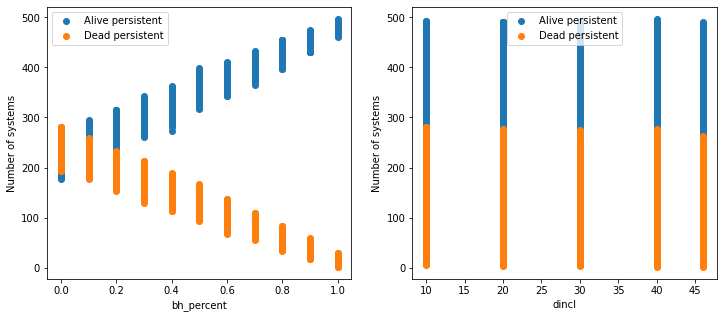

In [11]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].set_xlabel('bh_percent')
ax[0].set_ylabel('Number of systems')
ax[0].scatter(res2['bh'], res2['N_alive_persisitent'], label='Alive persistent')
ax[0].scatter(res2['bh'], res2['N_dead_persisitent'], label='Dead persistent')
ax[0].legend()


ax[1].set_xlabel('dincl')
ax[1].set_ylabel('Number of systems')
ax[1].scatter(res2['dincl'], res2['N_alive_persisitent'], label='Alive persistent')
ax[1].scatter(res2['dincl'], res2['N_dead_persisitent'], label='Dead persistent')
ax[1].legend()

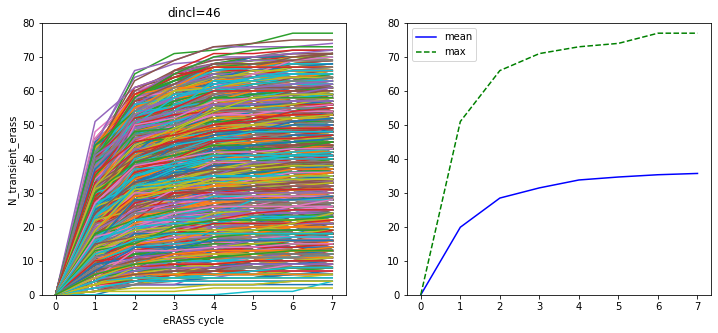

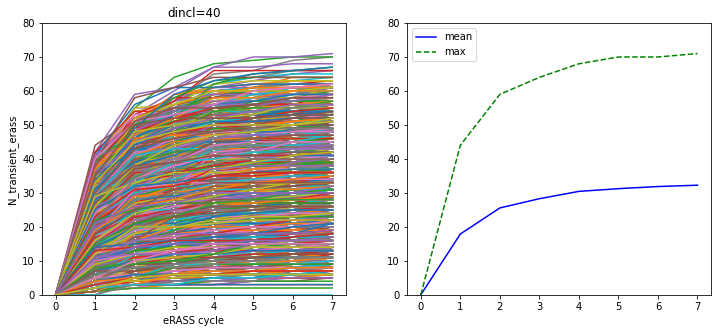

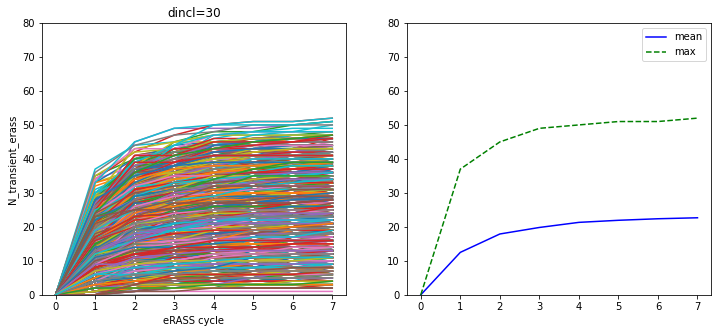

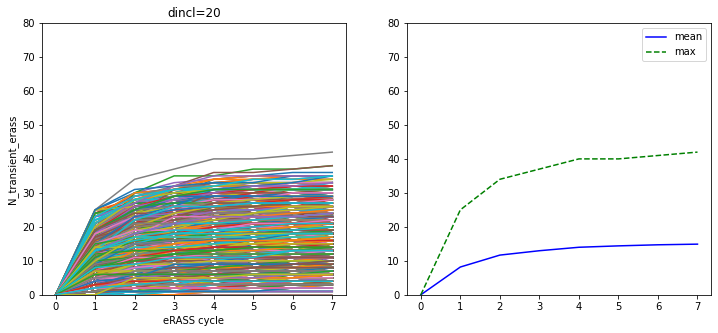

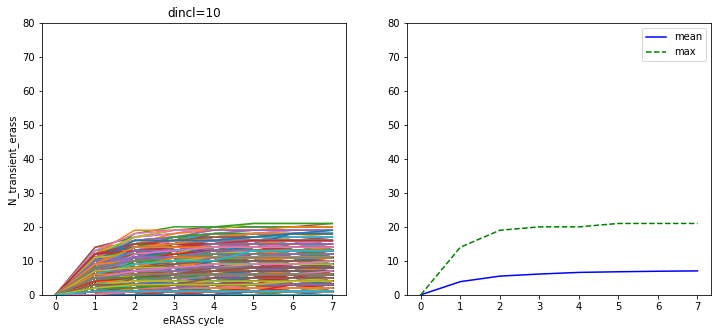

In [12]:
for dincl in res2['dincl'].unique():
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    ax[0].set_ylabel('N_transient_erass')
    ax[0].set_xlabel('eRASS cycle')
    ax[0].set_title(f'dincl={dincl}')
    ax[0].set_ylim(0,80)
    ax[1].set_ylim(0,80)
    
    sub = res2[res2['dincl'] == dincl]
    N_transient_erass = col2arr(sub, 'N_transient_erass_cumsum')
    
    mean = np.mean(N_transient_erass, axis=0)
    maximum  = np.max(N_transient_erass, axis=0)
    
    ax[1].plot(mean, c='blue', linestyle='-', label='mean')
    ax[1].plot(maximum, c='green', linestyle='--', label='max')
    ax[1].legend()
    for i, row in sub.iterrows():
        ax[0].plot(row['N_transient_erass_cumsum'])

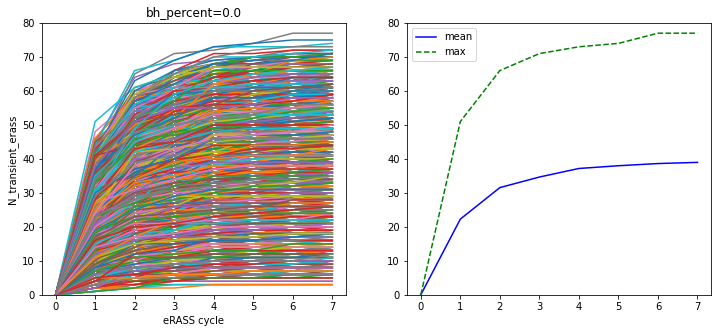

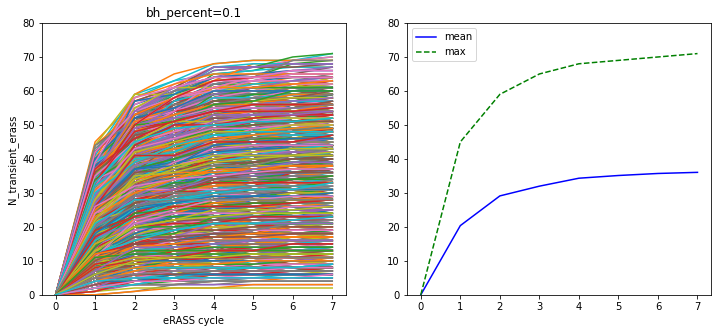

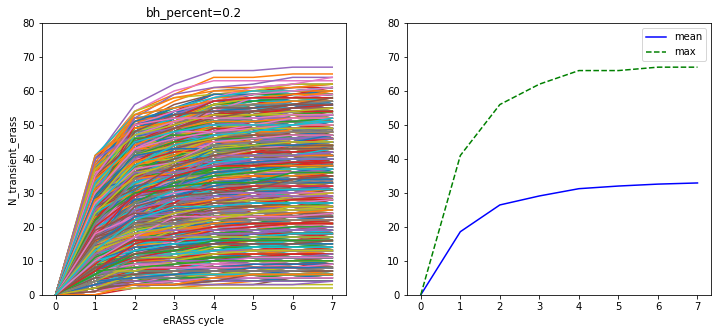

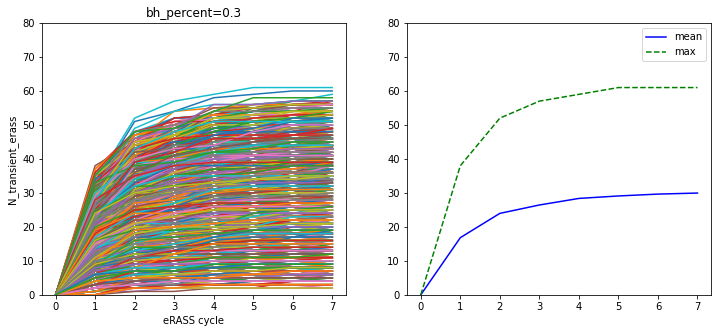

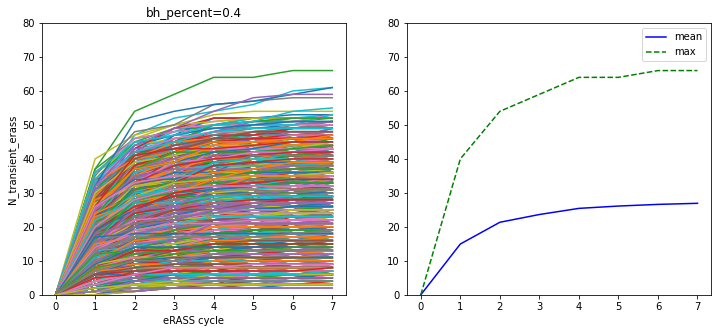

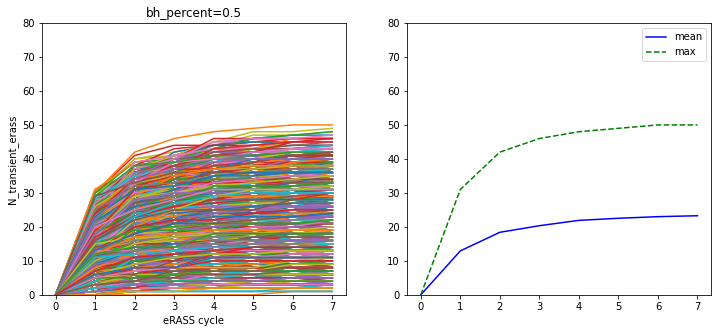

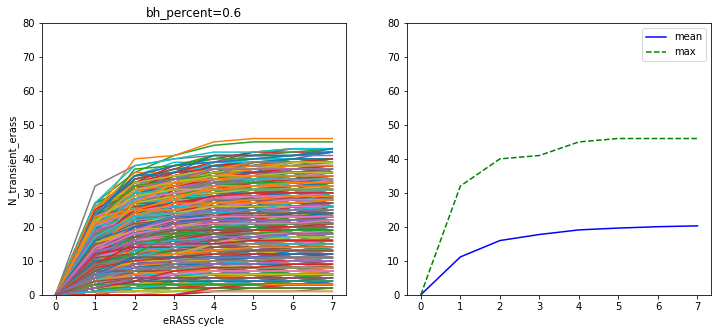

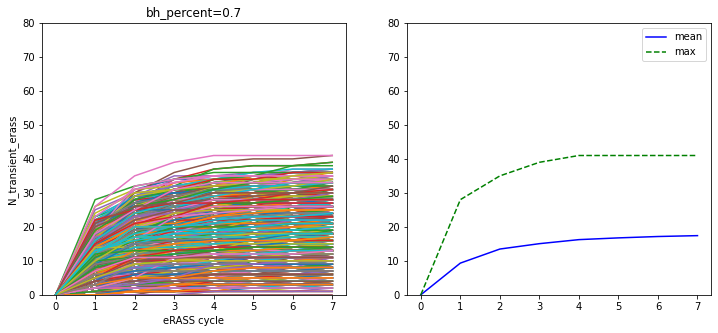

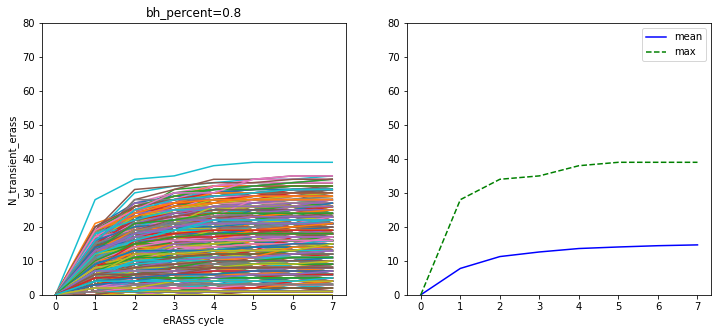

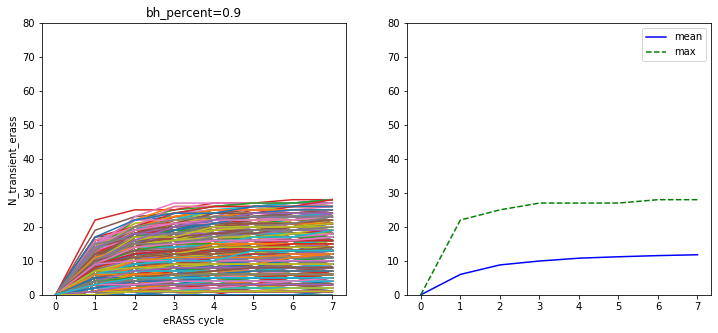

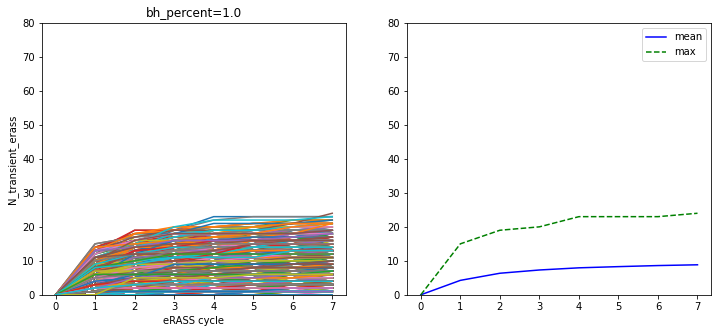

In [13]:
for bh in res2['bh'].unique():
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    ax[0].set_ylabel('N_transient_erass')
    ax[0].set_xlabel('eRASS cycle')
    ax[0].set_title(f'bh_percent={bh}')
    ax[0].set_ylim(0,80)
    ax[1].set_ylim(0,80)
    
    sub = res2[res2['bh'] == bh]
    mean = np.mean(np.array(list(sub['N_transient_erass_cumsum'])), axis=0)
    maximum  = np.max(np.array(list(sub['N_transient_erass_cumsum'])), axis=0)
    
    ax[1].plot(mean, c='blue', linestyle='-', label='mean')
    ax[1].plot(maximum, c='green', linestyle='--', label='max')
    ax[1].legend()
    for i, row in sub.iterrows():
        ax[0].plot(row['N_transient_erass_cumsum'])

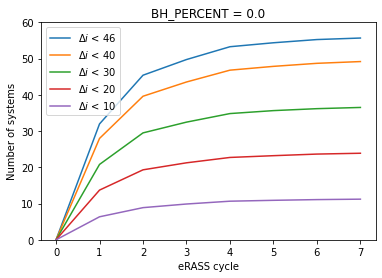

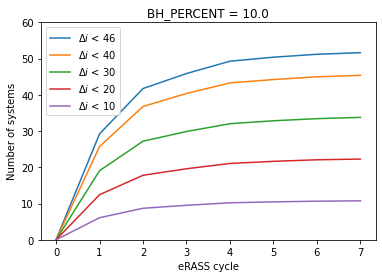

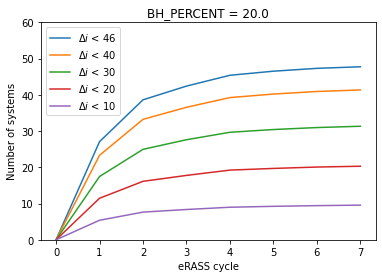

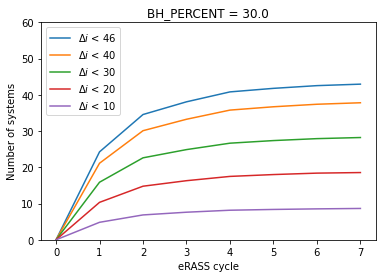

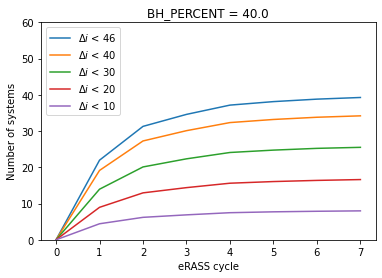

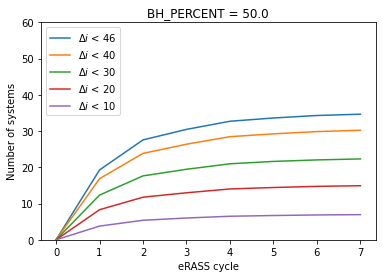

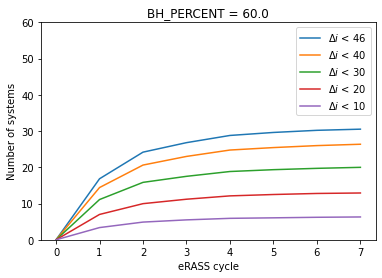

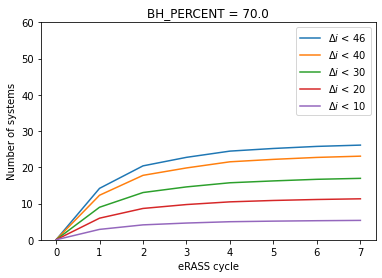

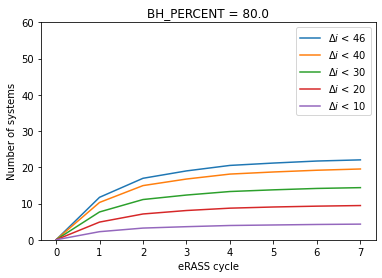

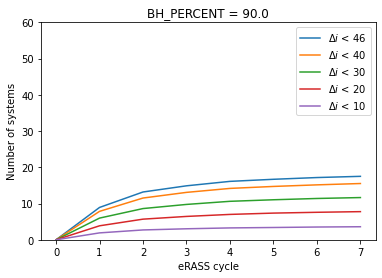

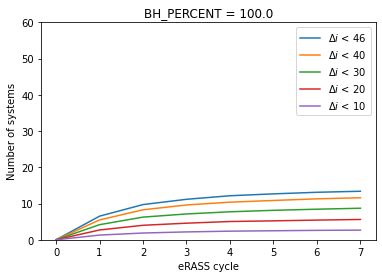

In [14]:
#eRASS transients alive/dead evolution
for bh in res2['bh'].unique():
    plt.figure(figsize=(6,4))
    plt.title(f'BH_PERCENT = {str(bh*100)}')
    plt.xlabel('eRASS cycle')
    plt.ylabel('Number of systems')
    plt.ylim(0,60)
    for dincl in res2['dincl'].unique():    
        sub = res2[(res2['dincl'] == dincl) & (res2['bh'] == bh)]   
        trans_means = np.array([np.array(x) for x in sub['N_transient_erass_cumsum'].values]).mean(axis=0)
        plt.plot(trans_means, label=f'$\Delta i$ < {dincl}')
    plt.savefig(f'../reports/figures/eRASS/transients_by_dincl_bh={bh}.png')
    plt.savefig(f'../reports/figures/eRASS/transients_by_dincl_dincl={bh}.eps')
    plt.savefig(f'../reports/figures/eRASS/transients_by_dincl_dincl={bh}.pdf')
    plt.legend()

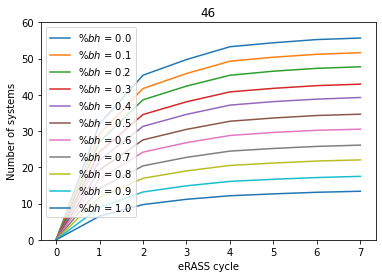

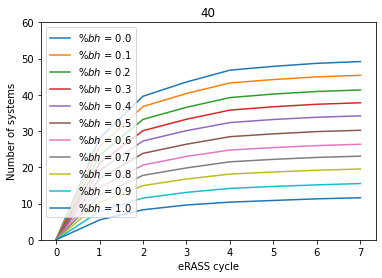

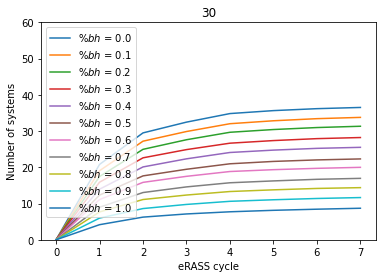

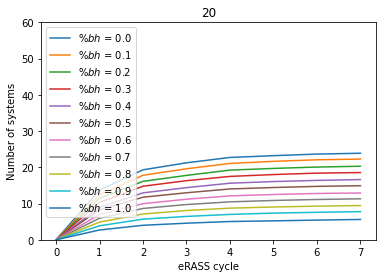

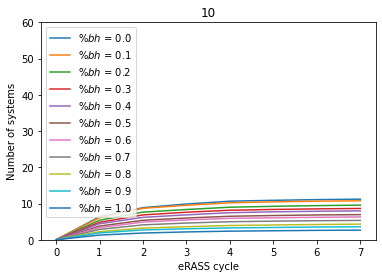

In [15]:
#eRASS transients alive/dead evolution
for dincl in res2['dincl'].unique():
    plt.figure(figsize=(6,4))
    plt.title(str(dincl))
    plt.xlabel('eRASS cycle')
    plt.ylabel('Number of systems')
    plt.ylim(0,60)
    

    for bh in res2['bh'].unique():
        sub = res2[(res2['dincl'] == dincl) & (res2['bh'] == bh)]   
        trans_means = np.array([np.array(x) for x in sub['N_transient_erass_cumsum'].values]).mean(axis=0)

        plt.plot(trans_means, label=f'$\%bh$ = {bh}')

    plt.legend()
    #plt.savefig(f'../reports/figures/eRASS/transients_by_bh_dincl={dincl}.png')
    #plt.savefig(f'../reports/figures/eRASS/transients_by_bh_dincl={dincl}.eps')
    #plt.savefig(f'../reports/figures/eRASS/transients_by_bh_dincl={dincl}.pdf')

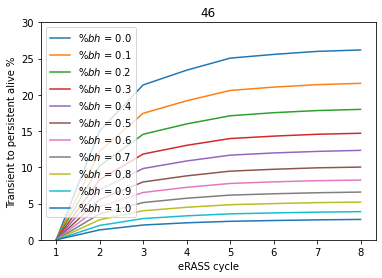

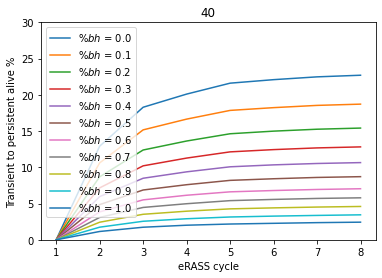

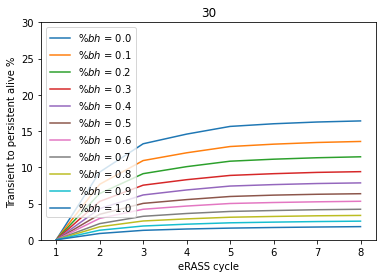

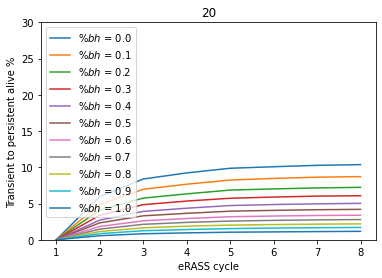

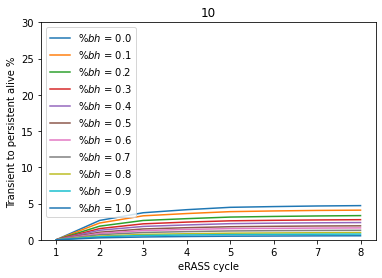

In [16]:
for dincl in res2['dincl'].unique():
    plt.figure(figsize=(6,4))
    plt.title(str(dincl))
    plt.xlabel('eRASS cycle')
    plt.ylabel('Transient to persistent alive %')
    plt.ylim(0,30)

    for bh in res2['bh'].unique():
        sub = res2[(res2['dincl'] == dincl) & (res2['bh'] == bh)]   
        
        persistent_alive_mean = sub['N_alive_persisitent'].mean()
        persistent_dead_mean = sub['N_dead_persisitent'].mean()
        
        trans_means = np.array([np.array(x) for x in sub['N_transient_erass_cumsum'].values]).mean(axis=0)
        
        plt.plot(np.arange(1,9), trans_means/persistent_alive_mean*100, label=f'$\%bh$ = {bh}')
    plt.legend()
    #plt.savefig(f'../reports/figures/eRASS/transients_by_bh_dincl={dincl}.png')
    #plt.savefig(f'../reports/figures/eRASS/transients_by_bh_dincl={dincl}.eps')
    #plt.savefig(f'../reports/figures/eRASS/transients_by_bh_dincl={dincl}.pdf')

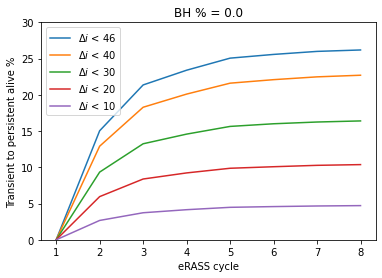

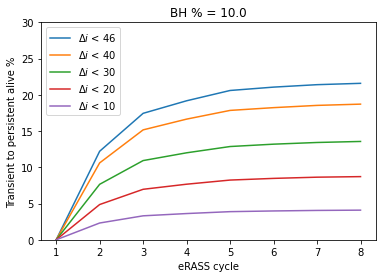

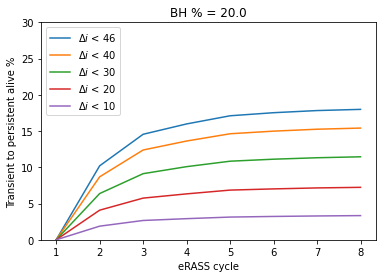

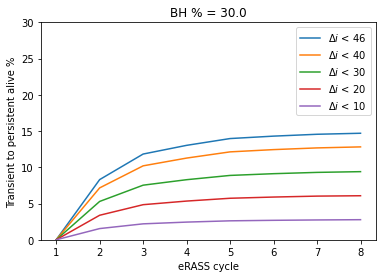

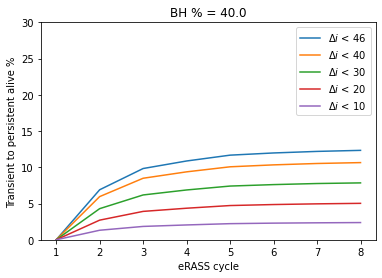

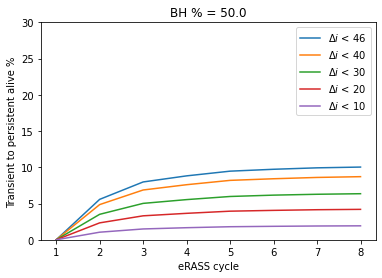

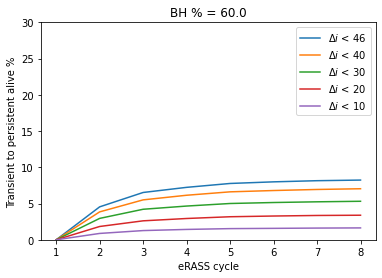

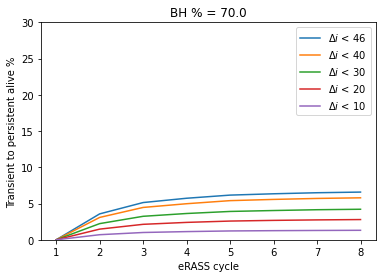

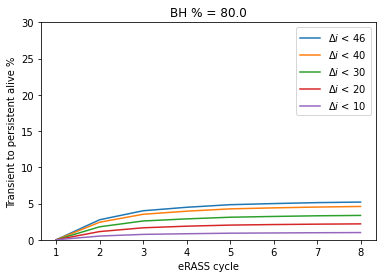

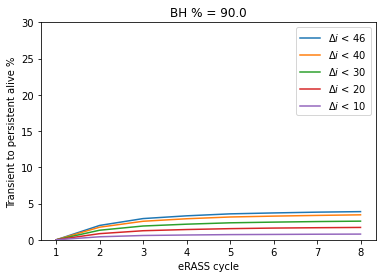

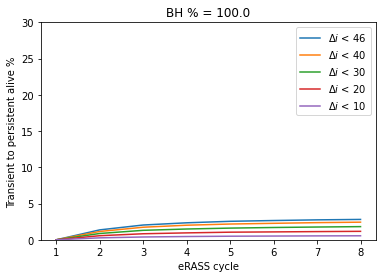

In [17]:
#eRASS transients alive/dead evolution
for bh in res2['bh'].unique():
    plt.figure(figsize=(6,4))
    
    plt.title(f'BH % = {str(bh*100)}')
    plt.xlabel('eRASS cycle')
    plt.ylabel('Transient to persistent alive %')
    plt.ylim(0,30)
    for i, dincl in enumerate(res2['dincl'].unique()):
        sub = res2[(res2['dincl'] == dincl) & (res2['bh'] == bh)]   
        
        persistent_alive_mean = sub['N_alive_persisitent'].mean()
        persistent_dead_mean = sub['N_dead_persisitent'].mean()
        
        trans_means = np.array([np.array(x) for x in sub['N_transient_erass_cumsum'].values]).mean(axis=0)
        
        plt.plot(np.arange(1,9), trans_means/persistent_alive_mean*100, label=f'$\Delta i$ < {dincl}')
    #plt.savefig(f'../reports/figures/eRASS/transients_by_dincl_bh={bh}.png')
    #plt.savefig(f'../reports/figures/eRASS/transients_by_dincl_dincl={bh}.eps')
    #plt.savefig(f'../reports/figures/eRASS/transients_by_dincl_dincl={bh}.pdf')
    plt.legend()

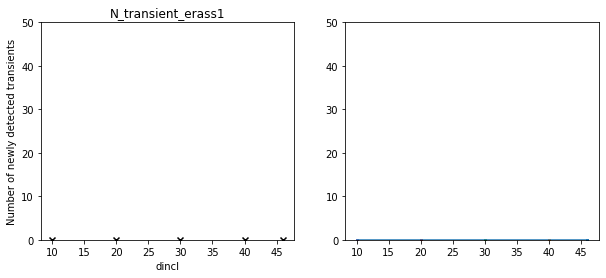

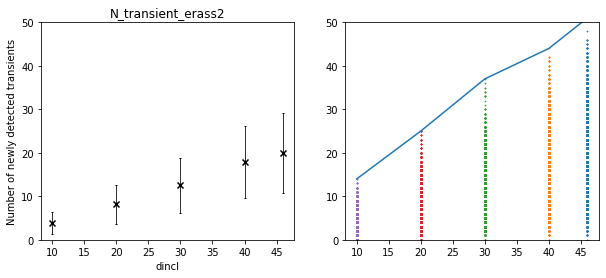

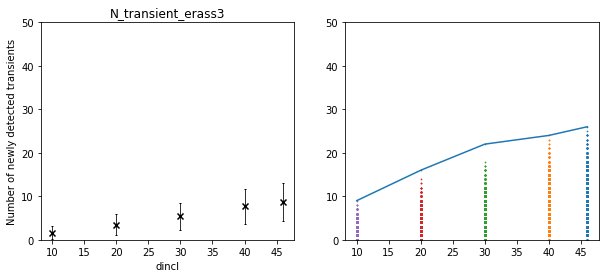

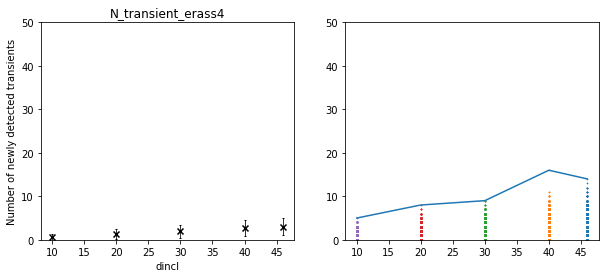

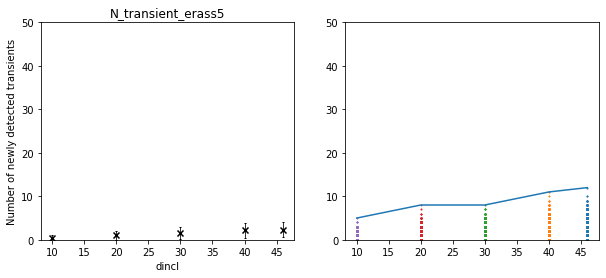

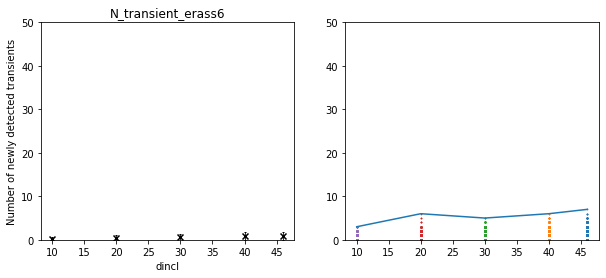

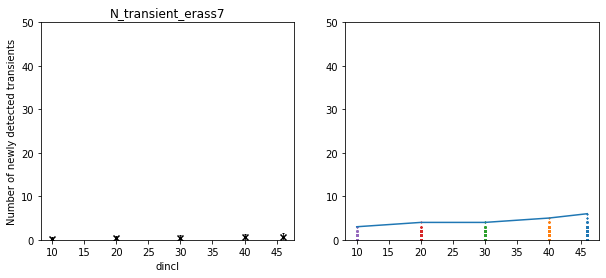

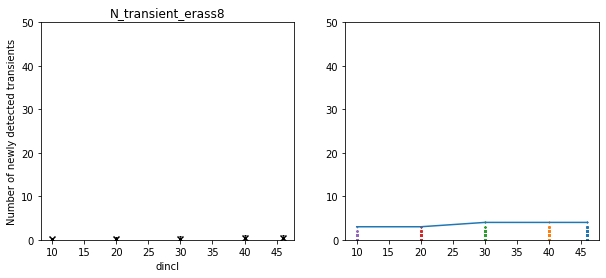

In [18]:

for col in transient_cols:
    maximums = []
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].set_title(col)
    ax[0].set_ylim(0,50)
    ax[1].set_ylim(0,50)
    
    ax[0].set_xlabel('dincl')
    ax[0].set_ylabel('Number of newly detected transients')
    for dincl in df['dincl'].unique():
        sub = df[df['dincl'] == dincl]
        maximum = sub[col].max()
        maximums.append(maximum)
        
        mean = sub[col].mean()
        std = sub[col].std()
        #print(mean, std)
        ax[1].scatter(sub['dincl'], sub[col], s=0.5)
    
        
        ax[0].scatter(dincl, mean, marker='x', c='black')
        ax[0].errorbar(dincl, mean, yerr=std, capsize=0.8, lw=0.8, c='black')
    
    ax[1].plot(df['dincl'].unique(), maximums)
        


In [19]:
df['dincl'].unique()

array([46, 40, 30, 20, 10])

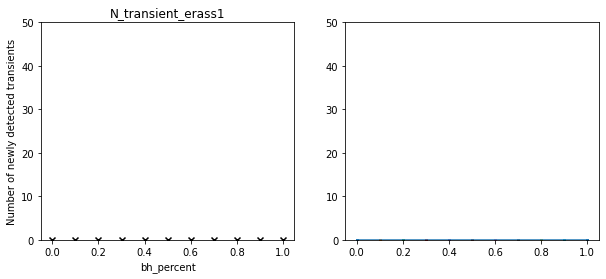

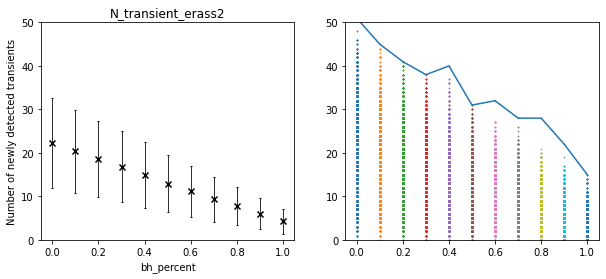

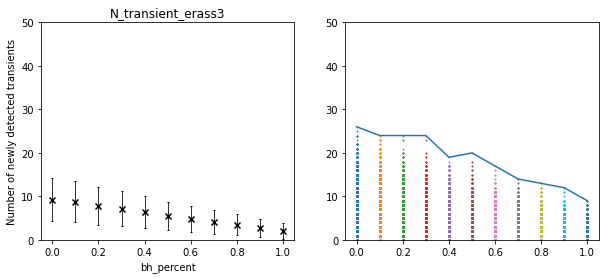

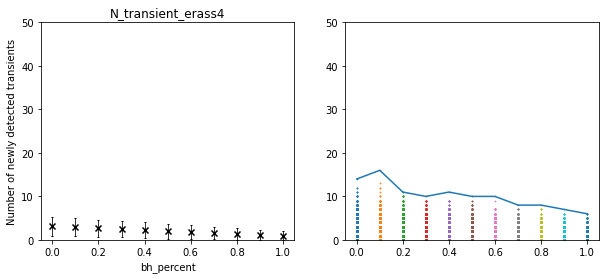

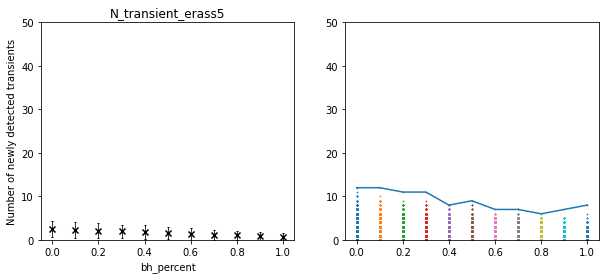

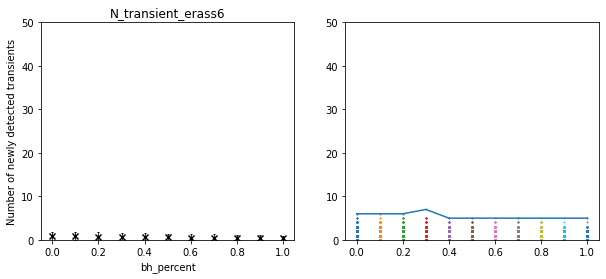

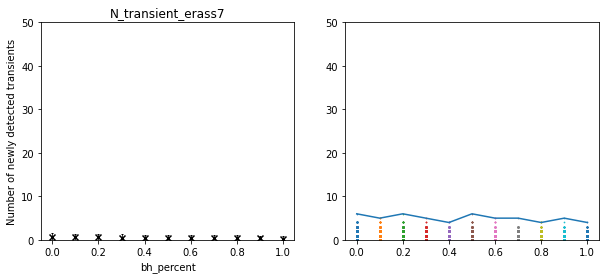

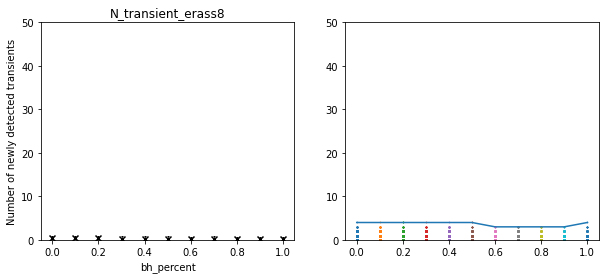

In [20]:
for col in transient_cols:
    maximums = []
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].set_title(col)
    ax[0].set_ylim(0,50)
    ax[1].set_ylim(0,50)
    
    ax[0].set_xlabel('bh_percent')
    ax[0].set_ylabel('Number of newly detected transients')
    for bh in df['bh_percent'].unique():
        sub = df[df['bh_percent'] == bh]
        maximum = sub[col].max()
        maximums.append(maximum)
        mean = sub[col].mean()
        std = sub[col].std()
        #print(mean, std)
        ax[1].scatter(sub['bh_percent'], sub[col], s=0.5)
        
        ax[0].scatter(bh, mean, marker='x', c='black')
        ax[0].errorbar(bh, mean, yerr=std, capsize=0.8, lw=0.8, c='black')
    ax[1].plot(df['bh_percent'].unique(), maximums)

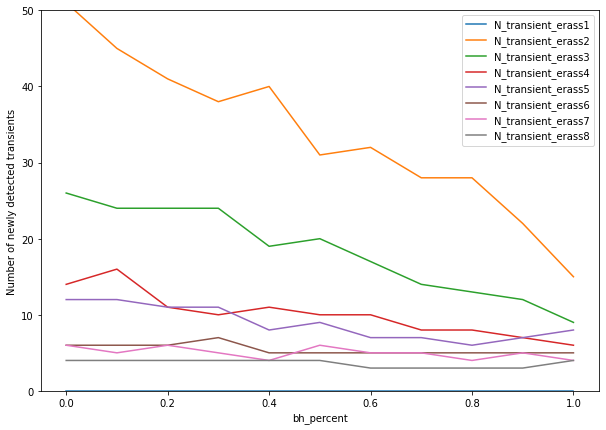

In [21]:
plt.figure(figsize=(10,7))
for col in transient_cols:
    maximums = []
    
    #plt.title(col)
    plt.ylim(0,50)
    
    plt.xlabel('bh_percent')
    plt.ylabel('Number of newly detected transients')
    for bh in df['bh_percent'].unique():
        sub = df[df['bh_percent'] == bh]
        maximum = sub[col].max()
        maximums.append(maximum)
        mean = sub[col].mean()
        std = sub[col].std()
        #print(mean, std)
        #ax[1].scatter(sub['bh_percent'], sub[col], s=0.5)
        
        #ax[0].scatter(bh, mean, marker='x', c='black')
        #ax[0].errorbar(bh, mean, yerr=std, capsize=0.8, lw=0.8, c='black')
    plt.plot(df['bh_percent'].unique(), maximums, label=col)
plt.legend()

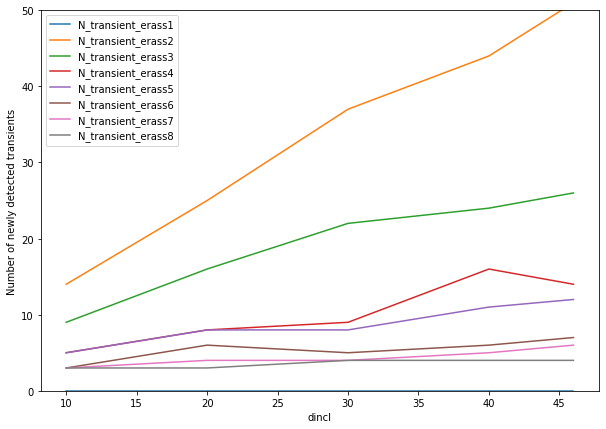

In [22]:
plt.figure(figsize=(10,7))
for col in transient_cols:
    maximums = []
    
    #plt.title(col)
    plt.ylim(0,50)
    
    plt.xlabel('dincl')
    plt.ylabel('Number of newly detected transients')
    for dincl in df['dincl'].unique():
        sub = df[df['dincl'] == dincl]
        maximum = sub[col].max()
        maximums.append(maximum)
        mean = sub[col].mean()
        std = sub[col].std()
        #print(mean, std)
        #ax[1].scatter(sub['bh_percent'], sub[col], s=0.5)
        
        #ax[0].scatter(bh, mean, marker='x', c='black')
        #ax[0].errorbar(bh, mean, yerr=std, capsize=0.8, lw=0.8, c='black')
    plt.plot(df['dincl'].unique(), maximums, label=col)
plt.legend()

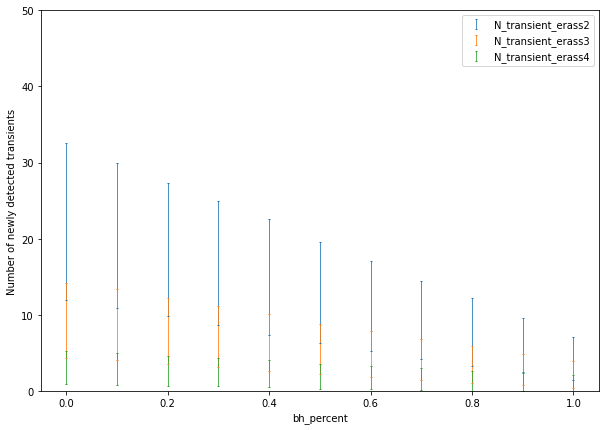

In [23]:
plt.figure(figsize=(10,7))
for col in transient_cols[1:4]:
    means = []
    stds = [] #meme
    
    #plt.title(col)
    plt.ylim(0,50)
    
    plt.xlabel('bh_percent')
    plt.ylabel('Number of newly detected transients')
    for bh in df['bh_percent'].unique():
        sub = df[df['bh_percent'] == bh]
        
        mean = sub[col].mean()
        std = sub[col].std()
        means.append(mean)
        stds.append(std)
        
        #print(mean, std)
        #ax[1].scatter(sub['bh_percent'], sub[col], s=0.5)
        
        #ax[0].scatter(bh, mean, marker='x', c='black')
        #ax[0].errorbar(bh, mean, yerr=std, capsize=0.8, lw=0.8, c='black')
        
    
    plt.errorbar(df['bh_percent'].unique(), means, yerr=stds, capsize=1.0, lw=0.8, label=col, linestyle='none')
plt.legend()

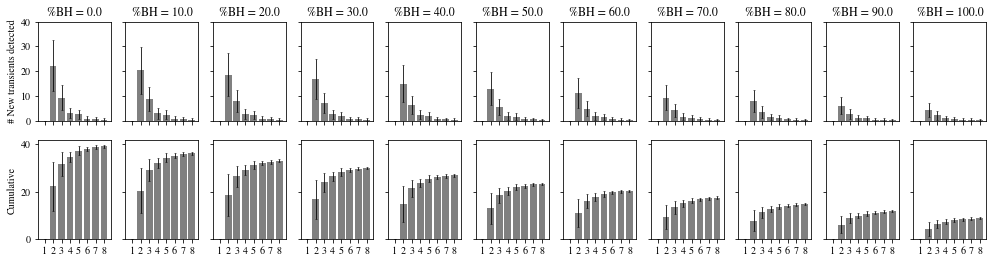

In [24]:
cycles = ['1', '2', '3', '4', '5', '6', '7', '8']
import matplotlib
fontsize = 10
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

dincls = df['dincl'].unique()
bh_percents = df['bh_percent'].unique()


fig, ax = plt.subplots(ncols=len(bh_percents), nrows=2, figsize=(17,4), sharey='row', sharex='col')
ax[0][0].set_ylabel('# New transients detected')
ax[1][0].set_ylabel('Cumulative')

for i, bh in enumerate(bh_percents):
    sub = df[df['bh_percent'] == bh]
    
    
    means = sub[transient_cols].mean()
    stds = sub[transient_cols].std()
    
    means_cum = sub[transient_cols_cumulative].mean()
    stds_cum = sub[transient_cols].std()
    
    
    ax[0][i].set_title(f'%BH = {bh*100}')
    ax[0][i].bar(cycles, means, yerr=stds, error_kw=dict(lw=0.8, capsize=1, capthick=0.5), color='grey')
    ax[0][i].set_ylim(0,40)
    
    ax[1][i].bar(cycles, means_cum, yerr=stds_cum, error_kw=dict(lw=0.8, capsize=1, capthick=0.5), color='grey')
    #ax[1][i].grid(axis='y')
    #ax[1][i].tick_params(axis='x', labelrotation=90)
    plt.savefig('../reports/figures/bh_num_transient_bar.eps', bbox_inches='tight')
    plt.savefig('../reports/figures/bh_num_transient_bar.png', bbox_inches='tight')

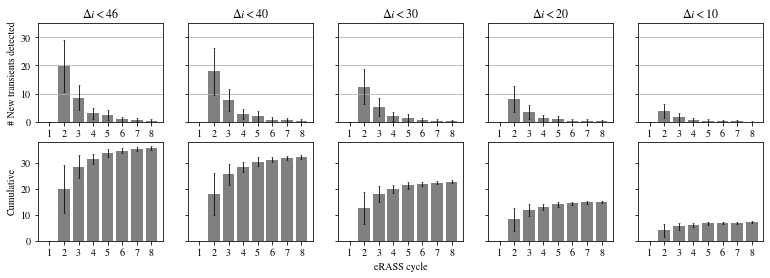

In [25]:
cycles = ['1', '2', '3', '4', '5', '6', '7', '8']

import matplotlib
fontsize = 10
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

dincls = df['dincl'].unique()
bh_percents = df['bh_percent'].unique()


fig, ax = plt.subplots(ncols=len(dincls), nrows=2, figsize=(13,4), sharey='row')
ax[0][0].set_ylabel('# New transients detected')
ax[1][0].set_ylabel('Cumulative')
ax[1][2].set_xlabel('eRASS cycle')


for i, dincl in enumerate(dincls):
    sub = df[df['dincl'] == dincl]
    
    means = sub[transient_cols].mean()
    stds = sub[transient_cols].std()
    
    means_cum = sub[transient_cols_cumulative].mean()
    stds_cum = sub[transient_cols].std()
    
    
    ax[0][i].set_title(f'$\Delta i < {dincl}$')
    ax[0][i].bar(cycles, means, yerr=stds, error_kw=dict(lw=0.8, capsize=1, capthick=0.5), color='grey')
    ax[0][i].set_ylim(0,35)
    ax[0][i].grid(axis='y')
    
    #ax[0][i].tick_params(labelrotation=90)
    
    ax[1][i].bar(cycles, means_cum, yerr=stds_cum, error_kw=dict(lw=0.8, capsize=1, capthick=0.5), color='grey')
    #ax[1][i].grid(axis='y')
    #ax[1][i].tick_params(axis='x', labelrotation=90)
    plt.savefig('../reports/figures/dincl_num_transient_bar.eps', bbox_inches='tight')
    plt.savefig('../reports/figures/dincl_num_transient_bar.png', bbox_inches='tight')

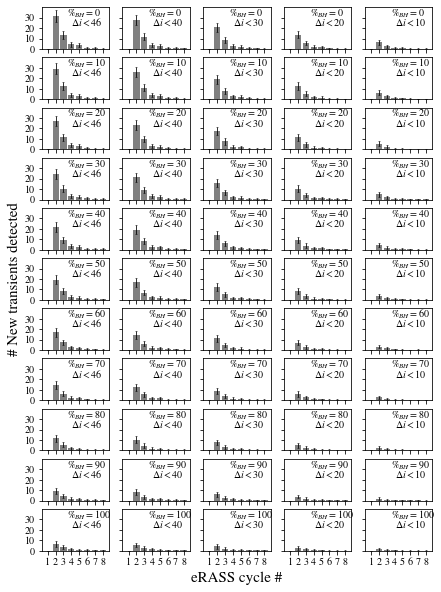

In [26]:
cycles = ['1', '2', '3', '4', '5', '6', '7', '8']
import matplotlib
fontsize = 10
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'


dincls = df['dincl'].unique()
bh_percents = df['bh_percent'].unique()


fig, ax = plt.subplots(nrows=len(bh_percents), ncols=len(dincls), figsize=(7,10), sharey='row', sharex='col')
#fig.tight_layout() 

ax[5][0].set_ylabel('# New transients detected', fontsize=15)
ax[-1][2].set_xlabel('eRASS cycle #', fontsize=15)


for j, bh in enumerate(bh_percents):
    for i, dincl in enumerate(dincls):
        sub = df[(df['bh_percent'] == bh) & (df['dincl'] == dincl)]


        means = sub[transient_cols].mean()
        stds = sub[transient_cols].std()

        


        #ax[i][j].set_title(f'{bh} {dincl}')
        ax[j][i].bar(cycles, means, yerr=stds, error_kw=dict(lw=0.8, capsize=1, capthick=0.5), color='grey')
        ax[j][i].set_ylim(0,40)
        ax[j][i].set_yticks([0, 10, 20, 30])
        
        ax[j][i].text(x=2.5, y=31, s=r'$\%_{{BH}} = {}$'.format(int(100*bh)))
        ax[j][i].text(x=3, y=22, s='$\Delta i < {}$'.format(dincl))
        
        #ax[j][0].set_ylabel('# New transients detected')

        #ax[j][i].grid(axis='y')
        #ax[j][i].tick_params(axis='x', labelrotation=90)

#plt.subplots_adjust(top = 2, bottom = 1, right = 2, left = 1, hspace = 0, wspace = 0)
#plt.margins(0,0)
plt.savefig('../reports/figures/bh_dincl_erass_mosaic_bar.eps', bbox_inches='tight')
plt.savefig('../reports/figures/bh_dincl_erass_mosaic_bar.png', bbox_inches='tight')

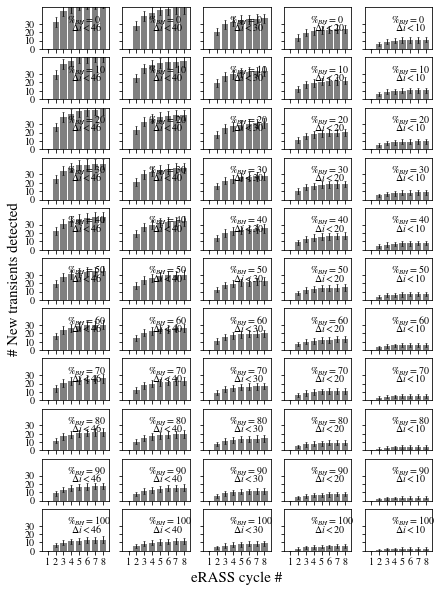

In [27]:
cycles = ['1', '2', '3', '4', '5', '6', '7', '8']
import matplotlib
fontsize = 10
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'


dincls = df['dincl'].unique()
bh_percents = df['bh_percent'].unique()


fig, ax = plt.subplots(nrows=len(bh_percents), ncols=len(dincls), figsize=(7,10), sharey='row', sharex='col')
#fig.tight_layout() 

ax[5][0].set_ylabel('# New transients detected', fontsize=15)
ax[-1][2].set_xlabel('eRASS cycle #', fontsize=15)


for j, bh in enumerate(bh_percents):
    for i, dincl in enumerate(dincls):
        sub = df[(df['bh_percent'] == bh) & (df['dincl'] == dincl)]


        means = sub[transient_cols_cumulative].mean()
        stds = sub[transient_cols_cumulative].std()

        


        #ax[i][j].set_title(f'{bh} {dincl}')
        ax[j][i].bar(cycles, means, yerr=stds, error_kw=dict(lw=0.8, capsize=1, capthick=0.5), color='grey')
        ax[j][i].set_ylim(0,50)
        ax[j][i].set_yticks([0, 10, 20, 30])
        
        ax[j][i].text(x=2.5, y=31, s=r'$\%_{{BH}} = {}$'.format(int(100*bh)))
        ax[j][i].text(x=3, y=22, s='$\Delta i < {}$'.format(dincl))
        
        #ax[j][0].set_ylabel('# New transients detected')

        #ax[j][i].grid(axis='y')
        #ax[j][i].tick_params(axis='x', labelrotation=90)

#plt.subplots_adjust(top = 2, bottom = 1, right = 2, left = 1, hspace = 0, wspace = 0)
#plt.margins(0,0)
plt.savefig('../reports/figures/bh_dincl_erass_mosaic_bar_cumsum.eps', bbox_inches='tight')
plt.savefig('../reports/figures/bh_dincl_erass_mosaic_bar_cumsum.png', bbox_inches='tight')

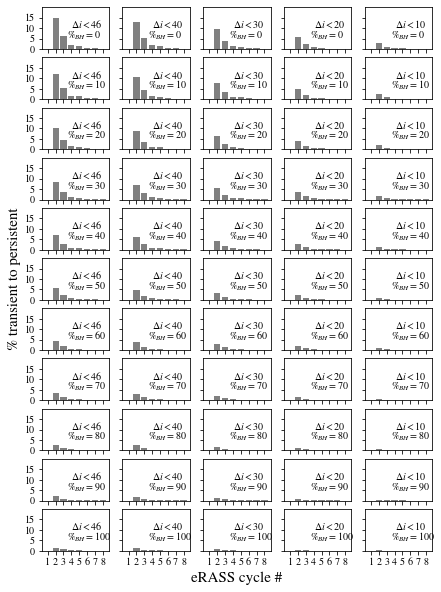

In [28]:
cycles = ['1', '2', '3', '4', '5', '6', '7', '8']
import matplotlib
fontsize = 10
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'


dincls = df['dincl'].unique()
bh_percents = df['bh_percent'].unique()


fig, ax = plt.subplots(nrows=len(bh_percents), ncols=len(dincls), figsize=(7,10), sharey='row', sharex='col')
#fig.tight_layout() 

ax[5][0].set_ylabel('% transient to persistent', fontsize=15)
ax[-1][2].set_xlabel('eRASS cycle #', fontsize=15)


for j, bh in enumerate(bh_percents):
    for i, dincl in enumerate(dincls):
        sub = df[(df['bh_percent'] == bh) & (df['dincl'] == dincl)]


        means = sub[transient_cols].mean()
        stds = sub[transient_cols].std()
        mean_persistent = sub['N_alive_persisitent'].mean()
        
        trans_to_persistent = means / mean_persistent * 100


        #ax[i][j].set_title(f'{bh} {dincl}')
        ax[j][i].bar(cycles, trans_to_persistent, error_kw=dict(lw=0.8, capsize=1, capthick=0.5), color='grey')
        ax[j][i].set_ylim(0,20)
        ax[j][i].set_yticks([0, 5, 10, 15])
        
        ax[j][i].text(x=2.5, y=5, s=r'$\%_{{BH}} = {}$'.format(int(100*bh)))
        ax[j][i].text(x=3, y=10, s='$\Delta i < {}$'.format(dincl))
        
        #ax[j][0].set_ylabel('# New transients detected')

        #ax[j][i].grid(axis='y')
        #ax[j][i].tick_params(axis='x', labelrotation=90)

#plt.subplots_adjust(top = 2, bottom = 1, right = 2, left = 1, hspace = 0, wspace = 0)
#plt.margins(0,0)
plt.savefig('../reports/figures/bh_dincl_erass_trans_persist_bar.eps', bbox_inches='tight')
plt.savefig('../reports/figures/bh_dincl_erass_trans_persist_bar.png', bbox_inches='tight')

No handles with labels found to put in legend.


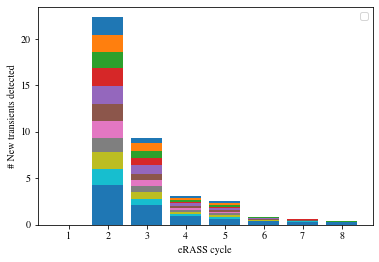

In [29]:
cycles = ['1', '2', '3', '4', '5', '6', '7', '8']
import matplotlib
fontsize = 10
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

dincls = df['dincl'].unique()
bh_percents = df['bh_percent'].unique()


plt.figure()
plt.ylabel('# New transients detected')
plt.xlabel('eRASS cycle')

for i, bh in enumerate(bh_percents):
    sub = df[df['bh_percent'] == bh]
    
    
    means = sub[transient_cols].mean()
    stds = sub[transient_cols].std()
    
    means_cum = sub[transient_cols_cumulative].mean()
    stds_cum = sub[transient_cols].std()
    
    
    
    plt.bar(cycles, means)
plt.legend()
    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


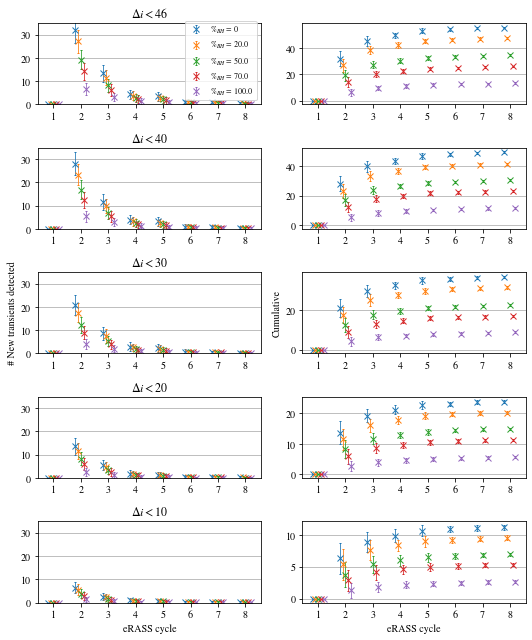

In [30]:
cycles = ['1', '2', '3', '4', '5', '6', '7', '8']

import matplotlib
fontsize = 10
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

dincls = df['dincl'].unique()
# bh_percents = df['bh_percent'].unique()
bh_percents = [0, 0.2, 0.5, 0.7, 1.0]

nbars = 8
spacing = 0.1


fig, ax = plt.subplots(ncols=2, nrows=len(dincls), figsize=(7.5,9))
ax[2][0].set_ylabel('# New transients detected')
ax[2][1].set_ylabel('Cumulative')
ax[-1][0].set_xlabel('eRASS cycle')
ax[-1][1].set_xlabel('eRASS cycle')


for i, dincl in enumerate(dincls):
    
    for j, bh in enumerate(bh_percents):
        sub = df[df['dincl'] == dincl]
        sub = sub[sub['bh_percent'] == bh]
        bh_label = f'$\%_{{BH}}$ = {bh*100}'
        
        means = sub[transient_cols].mean()
        stds = sub[transient_cols].std()

        means_cum = sub[transient_cols_cumulative].mean()
        stds_cum = sub[transient_cols].std()

        trans1 = Affine2D().translate(-spacing*(nbars)/4 + spacing*j, 0.0) + ax[i][0].transData
        trans2 = Affine2D().translate(-spacing*(nbars)/4 + spacing*j, 0.0) + ax[i][1].transData


        ax[i][0].set_title(f'$\Delta i < {dincl}$')
        ax[i][0].errorbar(cycles, means, yerr=stds, marker="x", linestyle="none",
                          linewidth=0.8, capsize=1.0, transform=trans1, label=bh_label)
        ax[i][0].set_ylim(0,35)
        ax[i][0].grid(axis='y')
        #ax[0][i].tick_params(labelrotation=90)

        ax[i][1].errorbar(cycles, means_cum, yerr=stds_cum, marker="x", linestyle="none",
                          linewidth=0.8, capsize=1.0, transform=trans2, label=bh_label)
        ax[i][1].grid(axis='y')
        #ax[1][i].grid(axis='y')
        #ax[1][i].tick_params(axis='x', labelrotation=90)

ax[0][0].legend(fontsize=8)
plt.tight_layout()
plt.savefig('../reports/figures/erass_dincl_bh_full.eps', bbox_inches='tight')
plt.savefig('../reports/figures/erass_dincl_bh_full.png', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


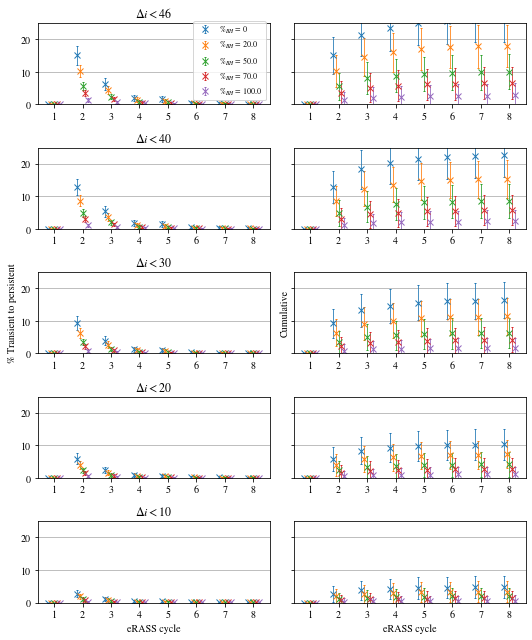

In [31]:
cycles = ['1', '2', '3', '4', '5', '6', '7', '8']

import matplotlib
fontsize = 10
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

dincls = df['dincl'].unique()
# bh_percents = df['bh_percent'].unique()
bh_percents = [0, 0.2, 0.5, 0.7, 1.0]

nbars = 8
spacing = 0.1


fig, ax = plt.subplots(ncols=2, nrows=len(dincls), figsize=(7.5,9), sharey='row')
ax[2][0].set_ylabel('% Transient to persistent')
ax[2][1].set_ylabel('Cumulative')
ax[-1][0].set_xlabel('eRASS cycle')
ax[-1][1].set_xlabel('eRASS cycle')


for i, dincl in enumerate(dincls):
    for j, bh in enumerate(bh_percents):

        sub = df[df['dincl'] == dincl]
        sub = sub[sub['bh_percent'] == bh]

        bh_label = f'$\%_{{BH}}$ = {bh*100}'

        means = sub[transient_cols].mean()
        stds = sub[transient_cols].std()
        mean_persistent = sub['N_alive_persisitent'].mean()
        mean_persistent_std = sub['N_alive_persisitent'].std()
        trans_to_persistent = means / mean_persistent * 100
        trans_to_persistent_std = trans_to_persistent * ( (mean_persistent_std/mean_persistent)**2 + (stds/means)**2)**0.5
    
        means_cum = sub[transient_cols_cumulative].mean()
        stds_cum = sub[transient_cols_cumulative].std()
        trans_to_persistent_cum = means_cum / mean_persistent * 100
        trans_to_persistent_cum_std = trans_to_persistent_cum * ( (mean_persistent_std/mean_persistent)**2 + (stds_cum/means_cum)**2)**0.5

        
        trans1 = Affine2D().translate(-spacing*(nbars)/4 + spacing*j, 0.0) + ax[i][0].transData
        trans2 = Affine2D().translate(-spacing*(nbars)/4 + spacing*j, 0.0) + ax[i][1].transData


        ax[i][0].set_title(f'$\Delta i < {dincl}$')
        ax[i][0].errorbar(cycles, trans_to_persistent, yerr=trans_to_persistent_std, marker="x", linestyle="none",
                          linewidth=0.8, capsize=1.0, transform=trans1, label=bh_label)
        ax[i][0].set_ylim(0,25)
        ax[i][0].grid(axis='y')
        #ax[0][i].tick_params(labelrotation=90)

        ax[i][1].errorbar(cycles, trans_to_persistent_cum, yerr=stds_cum, marker="x", linestyle="none",
                          linewidth=0.8, capsize=1.0, transform=trans2, label=bh_label)
        ax[i][1].grid(axis='y')
        #ax[1][i].grid(axis='y')
        #ax[1][i].tick_params(axis='x', labelrotation=90)

ax[0][0].legend(fontsize=8)
plt.tight_layout()
plt.savefig('../reports/figures/erass_dincl_bh_full_trans_persistent.eps', bbox_inches='tight')
plt.savefig('../reports/figures/erass_dincl_bh_full_trans_persistent.png', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


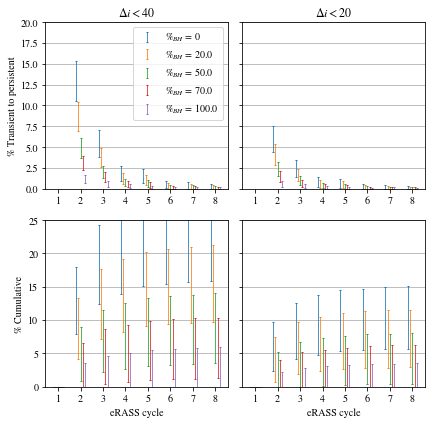

In [32]:
cycles = ['1', '2', '3', '4', '5', '6', '7', '8']
import matplotlib
fontsize = 10
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

#dincls = df['dincl'].unique()
# bh_percents = df['bh_percent'].unique()
dincls = [40,20]
bh_percents = [0, 0.2, 0.5, 0.7, 1.0]

nbars = 8
spacing = 0.1


fig, ax = plt.subplots(ncols=2, nrows=len(dincls), figsize=(6,6), sharey='row')

ax[-1][0].set_xlabel('eRASS cycle')
ax[-1][1].set_xlabel('eRASS cycle')


for i, dincl in enumerate(dincls):
    for j, bh in enumerate(bh_percents):

        sub = df[df['dincl'] == dincl]
        sub = sub[sub['bh_percent'] == bh]

        bh_label = f'$\%_{{BH}}$ = {bh*100}'

        means = sub[transient_cols].mean()
        stds = sub[transient_cols].std()
        mean_persistent = sub['N_alive_persisitent'].mean()
        mean_persistent_std = sub['N_alive_persisitent'].std()
        trans_to_persistent = means / mean_persistent * 100
        trans_to_persistent_std = trans_to_persistent * ( (mean_persistent_std/mean_persistent)**2 + (stds/means)**2)**0.5
    
        means_cum = sub[transient_cols_cumulative].mean()
        stds_cum = sub[transient_cols_cumulative].std()
        trans_to_persistent_cum = means_cum / mean_persistent * 100
        trans_to_persistent_cum_std = trans_to_persistent_cum * ( (mean_persistent_std/mean_persistent)**2 + (stds_cum/means_cum)**2)**0.5

        
        trans1 = Affine2D().translate(-spacing*(nbars)/4 + spacing*j, 0.0) + ax[0][i].transData
        trans2 = Affine2D().translate(-spacing*(nbars)/4 + spacing*j, 0.0) + ax[1][i].transData

        ax[0][i].errorbar(cycles, trans_to_persistent, yerr=trans_to_persistent_std, linestyle="none",
                          linewidth=0.8, capsize=1.0, transform=trans1, label=bh_label)


        ax[1][i].errorbar(cycles, trans_to_persistent_cum, yerr=stds_cum, linestyle="none",
                          linewidth=0.8, capsize=1.0, transform=trans2, label=bh_label)
        
        
        
        ax[0][i].set_title(f'$\Delta i < {dincl}$')

        
        ax[i][0].grid(axis='y')
        ax[i][1].grid(axis='y')
        #ax[1][i].grid(axis='y')
        #ax[0][i].tick_params(labelrotation=90)
        #ax[1][i].tick_params(axis='x', labelrotation=90)
        
ax[0][0].set_ylabel('% Transient to persistent')
ax[1][0].set_ylabel('% Cumulative')

ax[0][0].set_ylim(0,20)
ax[1][0].set_ylim(0,25)

ax[0][0].legend()
#ax[0][0].legend()

plt.subplots_adjust(wspace=0)

plt.tight_layout()
plt.savefig('../reports/figures/erass_dincl_bh_reduced_trans_persistent.eps', bbox_inches='tight')
plt.savefig('../reports/figures/erass_dincl_bh_reduced_trans_persistent.png', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


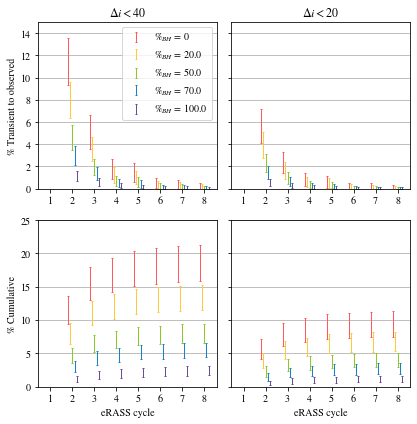

In [34]:
cycles = ['1', '2', '3', '4', '5', '6', '7', '8']
import matplotlib
fontsize = 10
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

#dincls = df['dincl'].unique()
# bh_percents = df['bh_percent'].unique()
dincls = [40,20]
bh_percents = [0, 0.2, 0.5, 0.7, 1.0]

nbars = 8
spacing = 0.1
linewidth = 1.0


fig, ax = plt.subplots(ncols=2, nrows=len(dincls), figsize=(6,6), sharey='row')

ax[-1][0].set_xlabel('eRASS cycle')
ax[-1][1].set_xlabel('eRASS cycle')

# z = x \pm y  error: (dx**2 + dy**2)**0.5
# z = x * y  error: z * ((dx/x)**2 + (dy/y)**2)**0.5

clist = ["#ff595e","#ffca3a","#8ac926","#1982c4","#6a4c93"]

for i, dincl in enumerate(dincls):
    for j, bh in enumerate(bh_percents):

        sub = df[df['dincl'] == dincl]
        sub = sub[sub['bh_percent'] == bh]

        bh_label = f'$\%_{{BH}}$ = {bh*100}'

        
        # Persistent
        mean_persistent = sub['N_alive_persisitent'].mean()
        mean_persistent_std = sub['N_alive_persisitent'].std()
        
        # Cycle specific
        means = sub[transient_cols].mean()
        stds = sub[transient_cols].std()

        
        persistent_plus_trans = means + mean_persistent
        persistent_plus_trans_std = (mean_persistent_std**2 + stds**2)**0.5
        
        trans_to_observed = means / persistent_plus_trans * 100
        trans_to_observed_std = trans_to_observed * ( (persistent_plus_trans_std/persistent_plus_trans)**2 + (stds/means)**2)**0.5
    
    
    
    
        # Cumulative
        means_cum = sub[transient_cols_cumulative].mean()
        stds_cum = sub[transient_cols_cumulative].std()
        
        persistent_plus_trans_cum = means_cum + mean_persistent
        persistent_plus_trans_cum_std = (mean_persistent_std**2 + stds_cum**2)**0.5
        
        trans_to_observed_cum = means_cum / (means_cum + mean_persistent) * 100
        trans_to_observed_cum_std = trans_to_observed_cum * ( (persistent_plus_trans_cum_std/persistent_plus_trans_cum)**2 + (stds_cum/means_cum)**2 )**0.5
        
        
        
        trans1 = Affine2D().translate(-spacing*(nbars)/4 + spacing*j, 0.0) + ax[0][i].transData
        trans2 = Affine2D().translate(-spacing*(nbars)/4 + spacing*j, 0.0) + ax[1][i].transData

        ax[0][i].errorbar(cycles, trans_to_observed, yerr=trans_to_observed_std, linestyle="none",
                          linewidth=linewidth, capsize=1.0, transform=trans1, label=bh_label, c=clist[j])


        ax[1][i].errorbar(cycles, trans_to_observed_cum, yerr=trans_to_observed_cum_std, linestyle="none",
                          linewidth=linewidth, capsize=1.0, transform=trans2, label=bh_label, c=clist[j])
        
        
        
        ax[0][i].set_title(f'$\Delta i < {dincl}$')

        
        ax[i][0].grid(axis='y')
        ax[i][1].grid(axis='y')
        #ax[1][i].grid(axis='y')
        #ax[0][i].tick_params(labelrotation=90)
        #ax[1][i].tick_params(axis='x', labelrotation=90)
        
ax[0][0].set_ylabel('% Transient to observed')
ax[1][0].set_ylabel('% Cumulative')

ax[0][0].set_ylim(0,15)
ax[1][0].set_ylim(0,25)

ax[0][0].legend()
#ax[0][0].legend()

plt.subplots_adjust(wspace=0)

plt.tight_layout()
plt.savefig('../reports/figures/erass_dincl_bh_reduced_trans_observed.eps', bbox_inches='tight')
plt.savefig('../reports/figures/erass_dincl_bh_reduced_trans_observed.png', bbox_inches='tight', dpi=1000)